In [1]:
# imports

# Models
from sklearn.base import BaseEstimator, TransformerMixin

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier as lgbm
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA

# pipelines
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline as PipeIMBL

# preprocessors
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, normalize
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif, SelectKBest, SelectFromModel, RFE

# Samplers
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.over_sampling import SMOTE

# metrics and splitters
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split

# utils
from sklearn.utils.validation import check_is_fitted
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import ParameterGrid
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
import sys
import matplotlib_venn as venn
import json

import upsetplot as uplt
import vae_utils
# progress bar
from ipywidgets import IntProgress
from IPython.display import display

sys.path.append("../")

import utils_ML as uml

import shap
shap.initjs()
plt.style.use('seaborn-dark')

In [2]:
import mysql.connector

conn = mysql.connector.connect(user='root', password='password', host='127.0.0.1', port='3306',database='expression_atlas_cells')
mycursor = conn.cursor(buffered = True)

# check the connection
if conn.is_connected():
    print("connection succesfull")
else:
    print("no connection")

seqsql = "SELECT protein.uniprot_id, protein.description FROM protein WHERE length IS NOT NULL"
uniprot_description = pd.read_sql_query(seqsql, conn)
uniprot_description.description = uniprot_description.description.apply(lambda x: x.split("(")[0])
uniprot_description = uniprot_description.set_index("uniprot_id")

connection succesfull


In [3]:
# read data

colors = sns.color_palette("bright")+sns.color_palette("pastel")
colors = colors[:15]

data = pd.read_csv("../preprocessing/quantile_norm_NSAF_50.csv", index_col = "assay_id")
with open("/home/compomics/Sam/git/python/master_thesis/Atlas_analysis/preprocessing/selected_features.txt", "r") as f:
    features = f.readlines()
    features = [x.strip() for x in features]
data = data.loc[:, features]
meta = pd.read_csv("../../Metadata/unified_metadata.csv")
meta = meta[meta.assay_id.isin(data.index)]

groups = pd.read_csv("../../Metadata/group_cells_annotation.csv", sep =";", index_col="Unnamed: 0")
meta["Group"] = meta.cell_line.apply(lambda x: groups[groups.cell_line == x]["group"].values[0])
meta = meta.set_index("assay_id")

data.sort_index(inplace=True)
meta.sort_index(inplace=True)

target_encoder = LabelEncoder()
targets = target_encoder.fit_transform(meta.Group)
unique_labels = pd.Series(targets).unique()

class_weights = compute_class_weight(class_weight='balanced', classes=unique_labels, y=targets)

weights = {unique_labels[i]: class_weights[i] for i in range(len(unique_labels))}
print(weights)

{2: 2.6564102564102563, 9: 0.7194444444444444, 11: 1.3282051282051281, 3: 2.3022222222222224, 1: 0.3453333333333333, 7: 3.453333333333333, 5: 1.4388888888888889, 0: 0.4427350427350427, 8: 1.5014492753623188, 12: 1.4388888888888889, 10: 1.3282051282051281, 6: 0.5755555555555556, 13: 1.817543859649123, 14: 3.453333333333333, 4: 0.8222222222222222}


In [4]:
feature_names = data.columns
dataset = data.reset_index(drop=True).rename(columns={data.columns[x]:x for x in range(len(data.columns))})

In [5]:
# Impute and scale

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(dataset, targets,
                                                    stratify=targets, 
                                                    test_size=0.20,
                                                    random_state=42)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
imputer = uml.LowestValueImputerGaussian()
imputer.fit(X_train,y_train)
X_train = imputer.transform(X_train, y_train)
X_test = imputer.transform(X_test, y_test)

print(X_train.isna().sum().sum())
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# Init
smote = SMOTE()
#vae = vae_utils.VariationalAutoencoder(6, 161, 50)
#vae.load_state_dict(torch.load("/home/compomics/Sam/git/python/master_thesis/Atlas_analysis/preprocessing/VAE_model_filtered"))

lr_smote = LogisticRegression(max_iter=10000, C=50, solver="liblinear", penalty="l2")
svc_smote = SVC(C=15, kernel="rbf", probability=True)
rf_smote = RandomForestClassifier(n_estimators = 150, criterion="entropy", max_depth = 10)

# Oversample
smote_oversampled, y_oversampled = smote.fit_resample(X_train, y_train)
#vae_oversampled, y_vae = vae_utils.resampleVAE(vae, X_train.to_numpy().astype("float32"), list(y_train), 10)

# Fit
lr_smote.fit(smote_oversampled, y_oversampled)
svc_smote.fit(smote_oversampled, y_oversampled)
rf_smote.fit(smote_oversampled, y_oversampled)

Y_pred_lr_smote = lr_smote.predict(X_test)
Y_pred_svc_smote = svc_smote.predict(X_test)
Y_pred_rf_smote = rf_smote.predict(X_test)

0


Show predictions per model

Text(252.5, 0.5, 'True label')

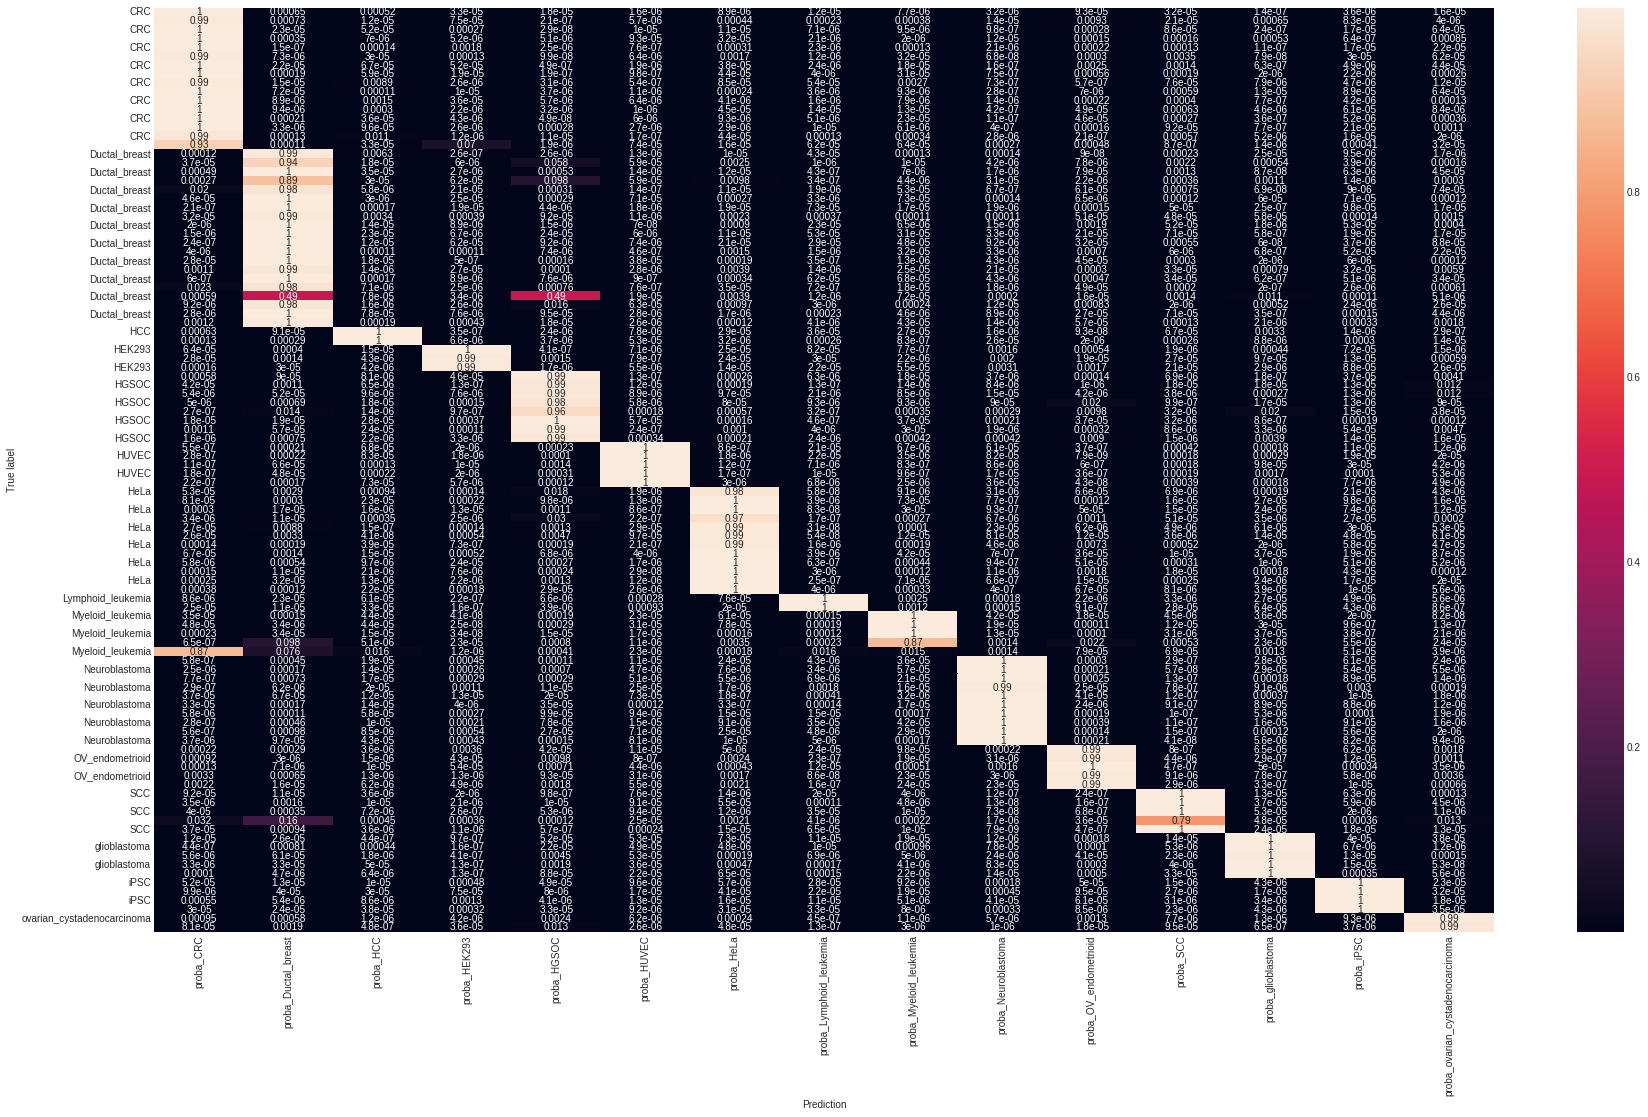

In [115]:
predictions_lr = pd.DataFrame({'prediction': target_encoder.inverse_transform(Y_pred_lr_smote), 'label': target_encoder.inverse_transform(y_test)})
predictions_lr["correct"] = predictions_lr.apply(lambda x: True if x["prediction"] == x["label"] else False, axis=1)
proba_predictions_lr = lr_smote.predict_proba(X_test)
predictions_lr = pd.concat([predictions_lr, pd.DataFrame(proba_predictions_lr, columns = ['proba_'+x for x in target_encoder.inverse_transform(lr_smote.classes_)])], axis = 1)
fig = plt.figure(figsize=(30,17))

s = sns.heatmap(predictions_lr.set_index('label').sort_index().iloc[:,2:], annot = True)
s.set_xlabel('Prediction')
s.set_ylabel('True label')

Text(252.5, 0.5, 'True label')

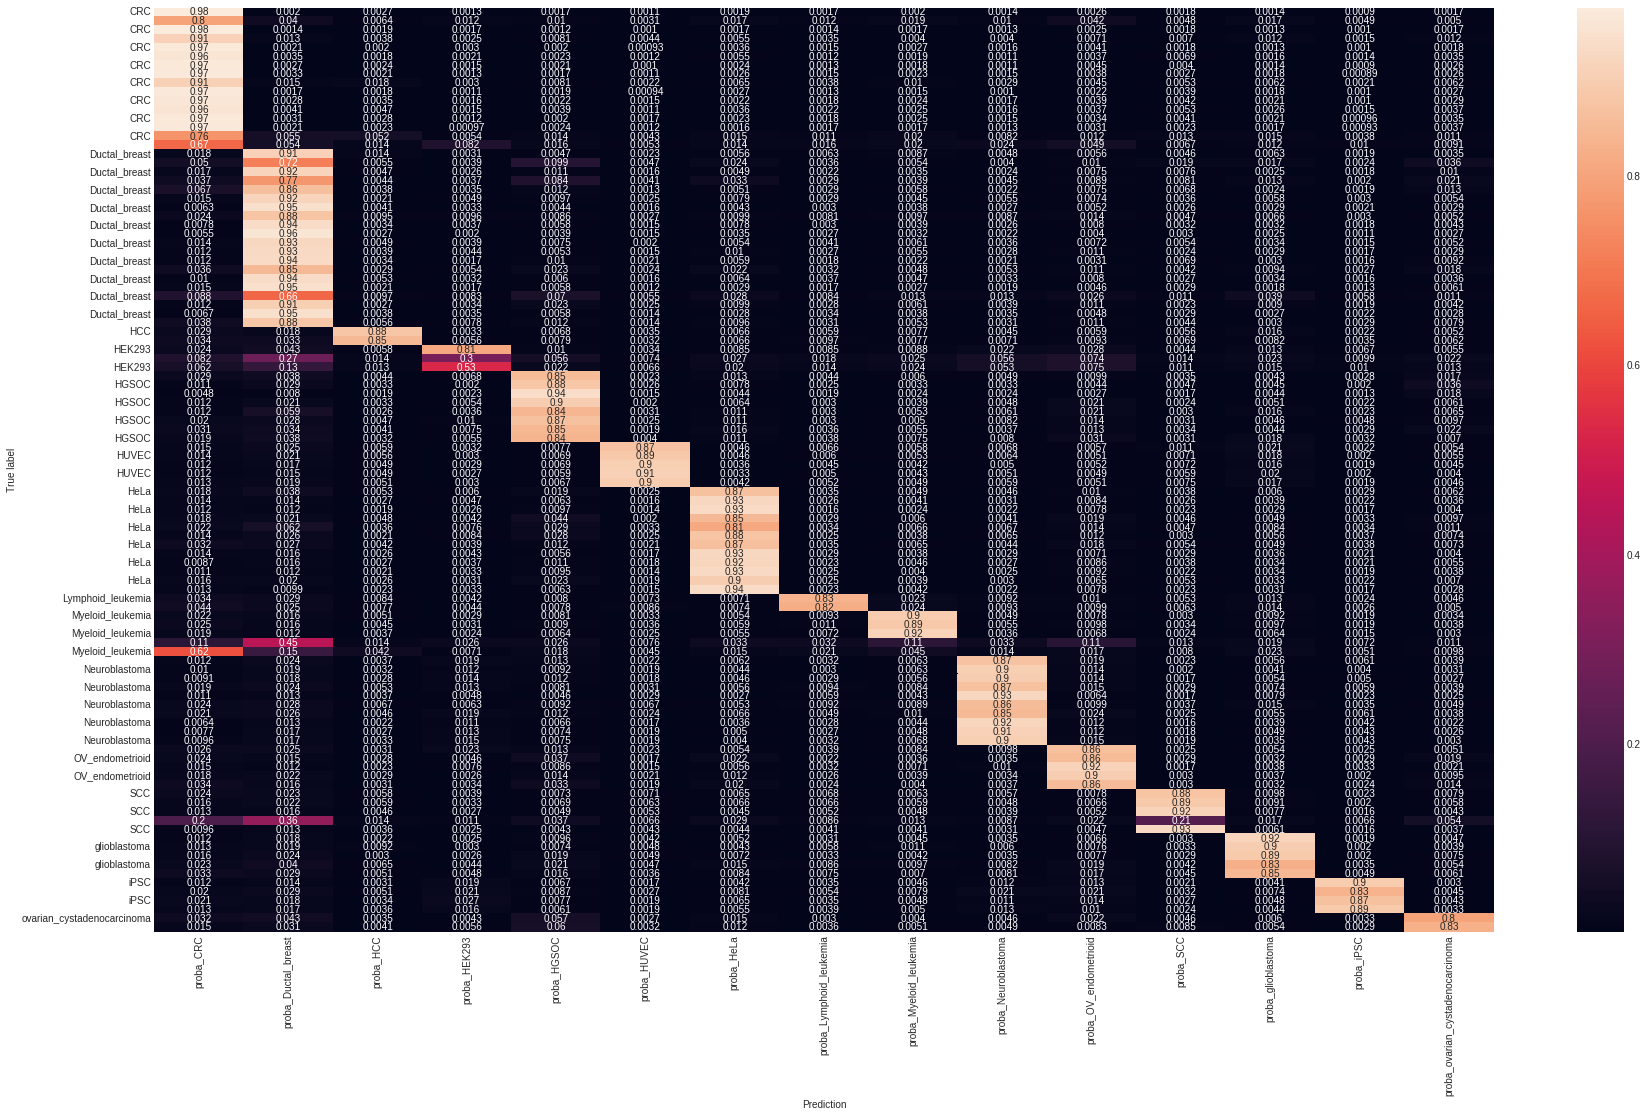

In [52]:
predictions_svc = pd.DataFrame({'prediction': target_encoder.inverse_transform(Y_pred_svc_smote), 'label': target_encoder.inverse_transform(y_test)})
predictions_svc["correct"] = predictions_svc.apply(lambda x: True if x["prediction"] == x["label"] else False, axis=1)
proba_predictions_svc = svc_smote.predict_proba(X_test)
predictions_svc = pd.concat([predictions_svc, pd.DataFrame(proba_predictions_svc, columns = ['proba_'+x for x in target_encoder.inverse_transform(svc_smote.classes_)])], axis = 1)
fig = plt.figure(figsize=(30,17))

s = sns.heatmap(predictions_svc.set_index('label').sort_index().iloc[:,2:], annot = True)
s.set_xlabel('Prediction')
s.set_ylabel('True label')

Text(252.5, 0.5, 'True label')

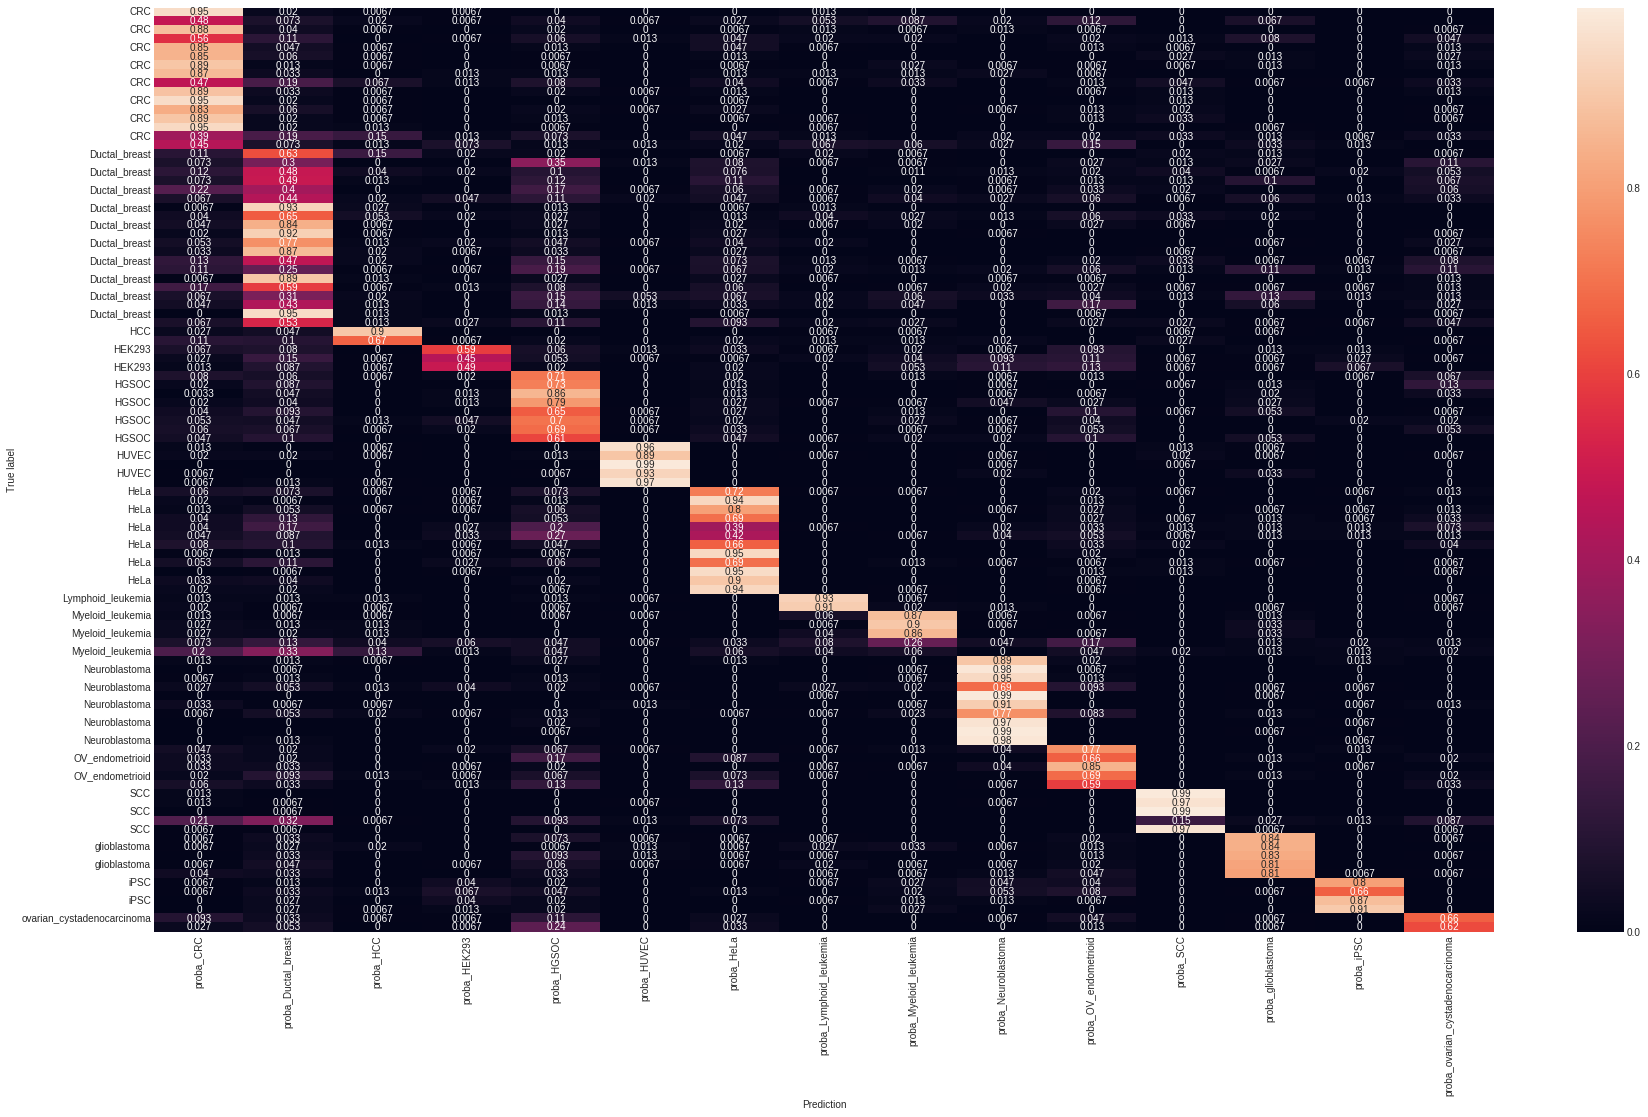

In [53]:
predictions_rf = pd.DataFrame({'prediction': target_encoder.inverse_transform(Y_pred_rf_smote), 'label': target_encoder.inverse_transform(y_test)})
predictions_rf["correct"] = predictions_rf.apply(lambda x: True if x["prediction"] == x["label"] else False, axis=1)
proba_predictions_rf = rf_smote.predict_proba(X_test)
predictions_rf = pd.concat([predictions_rf, pd.DataFrame(proba_predictions_rf, columns = ['proba_'+x for x in target_encoder.inverse_transform(rf_smote.classes_)])], axis = 1)
fig = plt.figure(figsize=(30,17))

s = sns.heatmap(predictions_rf.set_index('label').sort_index().iloc[:,2:], annot = True)
s.set_xlabel('Prediction')
s.set_ylabel('True label')

Get shap values for test set that are correctly predicted

In [ ]:
lr_correct_i = predictions_lr[predictions_lr["correct"]].index
x_lr_correct, y_lr_correct = X_test[lr_correct_i], y_test[lr_correct_i]

In [ ]:
svc_correct_i = predictions_svc[predictions_svc["correct"]].index
x_svc_correct, y_svc_correct = X_test[svc_correct_i], y_test[svc_correct_i]

In [ ]:
rf_correct_i = predictions_rf[predictions_rf["correct"]].index
x_rf_correct, y_rf_correct = X_test[rf_correct_i], y_test[rf_correct_i]

In [40]:
explainer_cpu_lr = shap.LinearExplainer(lr_smote, X_train)
shap_values_lr_test = explainer_cpu_lr.shap_values(x_lr_correct)
shap_values_lr_train = explainer_cpu_lr.shap_values(X_train)
print("LR explained")

LR explained


In [ ]:
explainer_cpu_svc = shap.KernelExplainer(svc_smote.predict_proba, X_train)
shap_values_svc_test = explainer_cpu_svc.shap_values(x_svc_correct)
shap_values_svc_train = explainer_cpu_svc.shap_values(X_train)
print("svc explained")

In [59]:
explainer_cpu_rf = shap.TreeExplainer(rf_smote, X_train)
shap_values_rf_test = explainer_cpu_rf.shap_values(x_rf_correct)
shap_values_rf_train = explainer_cpu_rf.shap_values(X_train)
print("RF explained")

100%|===================| 6183/6210 [01:47<00:00]        

RF explained


In [41]:
file1 = open("./shap_values/lr_test", "wb")
#file2 = open("./shap_values/svc_test", "wb")
#file3 = open("./shap_values/rf_test", "wb")

file4 = open("./shap_values/lr_train", "wb")
#file5 = open("./shap_values/svc_train", "wb")
#file6 = open("./shap_values/rf_train", "wb")

np.save(file1, np.array(shap_values_lr_test))
#np.save(file2, np.array(shap_values_svc_test))
#np.save(file3, np.array(shap_values_rf_test))

np.save(file4, np.array(shap_values_lr_train))
#np.save(file5, np.array(shap_values_svc_train))
#np.save(file6, np.array(shap_values_rf_train))

file1.close
#file2.close
#file3.close
file4.close
#file5.close
#file6.close

<function BufferedWriter.close>

In [28]:
file1 = open("./shap_values/x_lr_correct", "wb")
file2 = open("./shap_values/y_lr_correct", "wb")

np.save(file1, x_lr_correct)
np.save(file2, y_lr_correct)

file1.close
file2.close

<function BufferedWriter.close>

In [6]:
x_lr_correct = np.load("./shap_values/x_lr_correct")
y_lr_correct = np.load("./shap_values/y_lr_correct")

shap_lr_test = np.load("./shap_values/lr_test")
shap_lr_train = np.load("./shap_values/lr_train")
#shap_svc_test = np.load("./shap_values/svc_test")
#shap_svc_train = np.load("./shap_values/svc_train")
#shap_rf_test = np.load("./shap_values/rf_test")
#shap_rf_train = np.load("./shap_values/rf_train")

---

Import Gene ontology 

In [8]:
with open("GO_C_uniprot_map.json", 'r') as f:
    uniprot_go_compartment = json.load(f)

with open("GO_F_uniprot_map.json", 'r') as f:
    uniprot_go_function = json.load(f)

with open("GO_P_uniprot_map.json", 'r') as f:
    uniprot_go_process = json.load(f)

In [9]:
GO_description = pd.read_csv("../annotation_files/go_description.txt", sep="\t", index_col="GO_ID")

In [24]:
C_GO_prots = list(uniprot_go_compartment.keys())
F_GO_prots = list(uniprot_go_function.keys())
P_GO_prots = list(uniprot_go_process.keys())

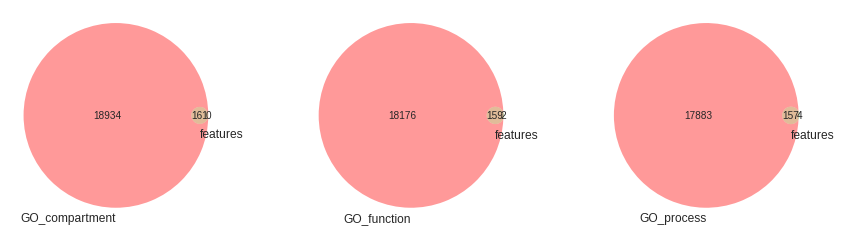

In [29]:
fig, ax = plt.subplots(1,3, figsize=(15,4))

venn.venn2(subsets=(set(C_GO_prots), set(features)), set_labels=("GO_compartment", "features"), ax=ax[0])
venn.venn2(subsets=(set(F_GO_prots), set(features)), set_labels=("GO_function", "features"), ax = ax[1])
venn.venn2(subsets=(set(P_GO_prots), set(features)), set_labels=("GO_process", "features"), ax = ax[2])

In [25]:
def return_missing_ontology(go_prots):
    missing_ontology = []
    for p in features:
        if p not in go_prots:
            missing_ontology.append(p)
    return missing_ontology

In [26]:
missing_ontology_C = return_missing_ontology(C_GO_prots)
uniprot_description.loc[missing_ontology_C,:]

Empty DataFrame
Columns: [description]
Index: []

In [27]:
missing_ontology_F = return_missing_ontology(F_GO_prots)
uniprot_description.loc[missing_ontology_F,:]

description
uniprot_id                                   
P43121       Cell surface glycoprotein MUC18 
Q3KQU3      MAP7 domain-containing protein 1

In [28]:
missing_ontology_P = return_missing_ontology(P_GO_prots)
uniprot_description.loc[missing_ontology_P,:]

description
uniprot_id                                                   
Q07065                     Cytoskeleton-associated protein 4 
Q53EP0      Fibronectin type III domain-containing protein...
Q8IWE2                                        Protein NOXP20 
Q96HQ2                      CDKN2AIP N-terminal-like protein

---

# Global importance

In [106]:
shap_values_lr_test = explainer_cpu_lr.shap_values(x_lr_correct)
shap_values_lr_train = explainer_cpu_lr.shap_values(X_train)

In [38]:
shap_values_transposed = shap_lr_test.transpose(1,2, 0)

In [107]:
shap_lr_test.shape

(15, 103, 161)

In [108]:
x_lr_correct.shape

(103, 161)

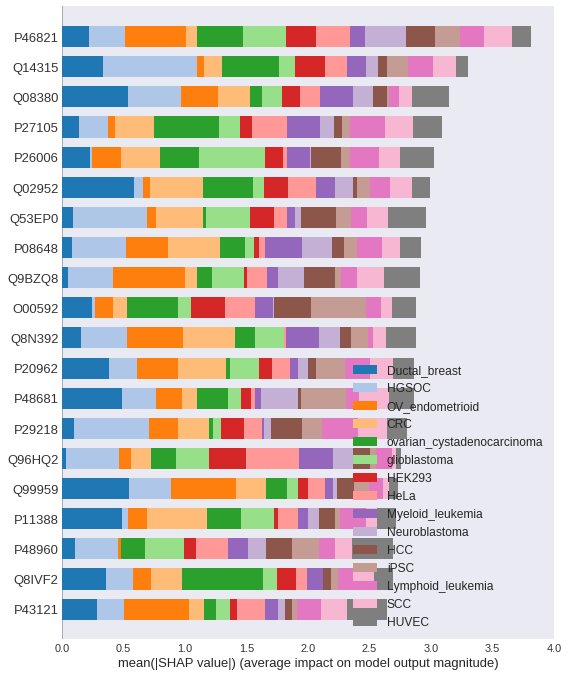

In [8]:
shap.summary_plot(list(shap_lr_train), X_train ,plot_type="bar", class_names= target_encoder.inverse_transform(lr_smote.classes_), feature_names = feature_names,
            color=plt.get_cmap("tab20"), max_display = 20)

P46821 is most important: Microtubule-associated protein 1B

In [10]:
summary_lr = {"uniprot_id": [], "shap_mean": []}
for feature in range(161):
    summed_mean = 0
    for c in range(15):
        summed_mean += np.mean(abs(shap_lr_test[c,:,feature]))
    summary_lr["uniprot_id"].append(feature_names[feature])
    summary_lr["shap_mean"].append(summed_mean)

summary_lr = pd.DataFrame(summary_lr).sort_values(by="shap_mean",ascending=False)

In [11]:
summary_lr_train = {"uniprot_id": [], "shap_mean": []}
for feature in range(161):
    summed_mean = 0
    for c in range(15):
        summed_mean += np.mean(abs(shap_lr_train[c,:,feature]))
    summary_lr_train["uniprot_id"].append(feature_names[feature])
    summary_lr_train["shap_mean"].append(summed_mean)

summary_lr_train = pd.DataFrame(summary_lr_train).sort_values(by="shap_mean",ascending=False)

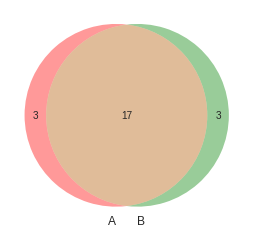

In [12]:
venn.venn2((set(summary_lr[:20].uniprot_id), set(summary_lr_train[:20].uniprot_id)))

In [10]:
summary_lr[:10]

uniprot_id  shap_mean
65      P46821   3.934804
92      Q14315   3.299851
83      Q08380   3.067592
47      P26006   3.054555
66      P48681   3.047276
104     Q53EP0   3.011935
135     Q9BZQ8   2.996410
43      P20962   2.949217
20      P08648   2.911943
80      Q02952   2.907023

In [74]:
set(summary_rf[-10:].uniprot_id).intersection(set(summary_lr[-10:].uniprot_id))

{'P46821', 'Q02952'}

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


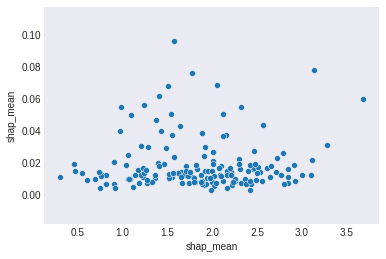

In [66]:
sns.scatterplot(summary_lr["shap_mean"], summary_rf["shap_mean"])

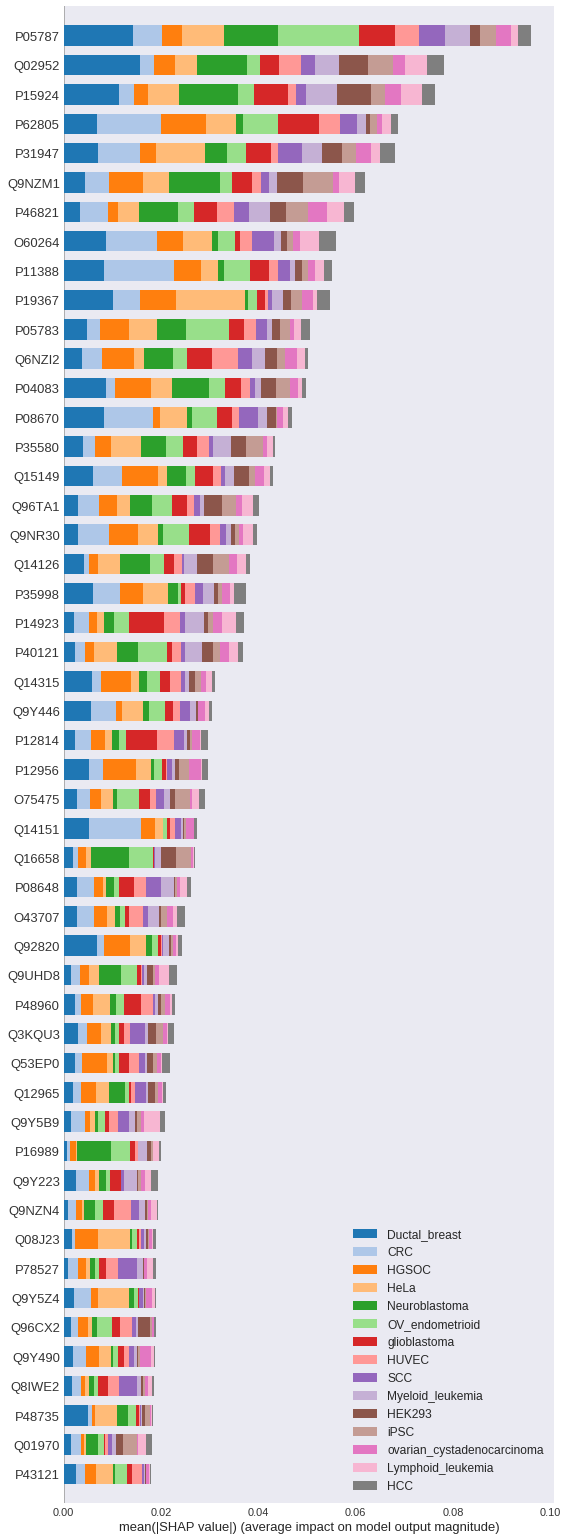

In [67]:
shap.summary_plot(list(shap_rf_test), x_rf_correct, plot_type="bar", class_names= target_encoder.inverse_transform(rf_smote.classes_), feature_names = feature_names,
            color=plt.get_cmap("tab20"), max_display = 50)

Get rank plots for the SHAPS per class

In [28]:
def rank_plot_shap(shaps, y, color=False, threshold=False, top_n=False):
    fig, ax = plt.subplots(5,3, figsize=(20,20))
    
    y_axis = 0
    x_axis = 0

    if color:
        pos_shaps_ids, _ = get_stats_shap_threshold(shaps,y,top_n=top_n,threshold=threshold, return_by_list=True)

    for i in range(15):
        
        # Get the table of shap values for class i
        shaps_df = pd.DataFrame(shaps[i], columns=features)

        # Create dataframe with mean and std of the shap values for the test_samples corresponding to that class 
        stat_shaps_df = pd.DataFrame(shaps_df.loc[y == i,:].mean(), columns = ["mean"])
        stat_shaps_df["std"] = shaps_df.loc[y == i,:].std()

        stat_shaps_df = stat_shaps_df["mean"].sort_values().reset_index()
        stat_shaps_df["x_axis"] = list(range(161))

        ax[y_axis][x_axis].set_title(target_encoder.inverse_transform([i])[0])
        sns.scatterplot(data=stat_shaps_df, x="x_axis", y="mean", ax=ax[y_axis][x_axis], hue=["not selected"]*(161-len(pos_shaps_ids[i])) + ["selected"]*len(pos_shaps_ids[i]))
        ax[y_axis][x_axis].set_xlabel("")
        ax[y_axis][x_axis].set_ylabel("Mean SHAP")
        # Create cumulative distribution plot of the mean shap value of the proteins to see whether a few proteins have large shap value means for each class
        # This enables to inituitively select top % features based on their shap values
        # ax[x_axis][y_axis].set_title(target_encoder.inverse_transform([i]))
        # sns.ecdfplot(abs(stat_shaps_df['mean']), ax=ax[x_axis][y_axis])

        y_axis += 1
        if y_axis == 5:
            y_axis=0
            x_axis+=1

def get_stats_shap(shaps, y):
    '''Returns pos_shaps (counts), class_proteins (dict)'''
    pos_shaps_lr = []
    class_proteins_lr = {}
    for i in range(15):
        
        class_name = target_encoder.inverse_transform([i])[0]
        # Get the table of shap values for class i
        shaps_df = pd.DataFrame(shaps[i], columns=features)

        # Create dataframe with mean and std of the shap values for the test_samples corresponding to that class 
        stat_shaps_df = pd.DataFrame(shaps_df.loc[y == i,:].mean(), columns = ["mean"])
        stat_shaps_df["std"] = shaps_df.loc[y == i,:].std()

        class_proteins_lr[class_name] = stat_shaps_df.index[stat_shaps_df["mean"] > 0].tolist()
        pos_shaps_lr.append(len(class_proteins_lr[class_name]))

        print(class_name , len(class_proteins_lr[class_name]))
    return pos_shaps_lr, class_proteins_lr

def get_stats_shap_threshold(shaps, y, std_lower=1.96, std_higher=1.96, top_n=False, threshold=False, return_by_list=True):
    class_proteins_svc_pos = {}
    class_proteins_svc_neg = {}
    class_top_n = {}

    prot_pos = []
    prot_neg = []
    top_n_list = []

    for i in range(15):
        
        class_name = target_encoder.inverse_transform([i])[0]

        # Get the table of shap values for class i
        shaps_df = pd.DataFrame(shaps[i], columns=features)

        # Create dataframe with mean and std of the shap values for the test_samples corresponding to that class 
        stat_shaps_df = pd.DataFrame(shaps_df.loc[y == i,:].mean(), columns = ["mean"])
        stat_shaps_df["std"] = shaps_df.loc[y == i,:].std()

        stat_shaps_df = stat_shaps_df["mean"].sort_values().reset_index()
        stat_shaps_df["x_axis"] = list(range(161))
        
        if top_n:
            class_top_n[class_name] = list(stat_shaps_df["index"][-top_n:])
            top_n_list.append(list(stat_shaps_df["index"][-top_n:]))
            
        if threshold:
            class_top_n[class_name] = list(stat_shaps_df[stat_shaps_df["mean"]>threshold]["index"])
            top_n_list.append(list(stat_shaps_df[stat_shaps_df["mean"]>threshold]["index"]))

        
        # Get significantly positive shap values (most important features)
        mean_of_means, std_of_means = stat_shaps_df["mean"].mean(), stat_shaps_df["mean"].std()
        threshold_pos = mean_of_means + std_higher*std_of_means
        sign_proteins_pos = stat_shaps_df["index"][stat_shaps_df["mean"] > threshold_pos].tolist()
        class_proteins_svc_pos[class_name] = sign_proteins_pos

        threshold_neg = mean_of_means - std_lower*std_of_means
        sign_proteins_neg = stat_shaps_df["index"][stat_shaps_df["mean"] < threshold_neg].tolist()
        class_proteins_svc_neg[class_name] = sign_proteins_neg

        prot_pos.append(sign_proteins_pos)
        prot_neg.append(sign_proteins_neg)

    if top_n or threshold:
        if return_by_list:
            return top_n_list, "_"
        return class_top_n, "_"
    
    if return_by_list:
        return prot_pos, prot_neg
    return class_proteins_svc_pos, class_proteins_svc_neg

def get_df_shap(shaps, label, thresh=False, std_lower=1.96, std_higher=1.96):
    shaps_df = pd.DataFrame(shaps[label], column=features)
    stat_shaps_df = pd.DataFrame(shaps_df.loc[y_train_df == label,:].mean(), columns = ["mean"])

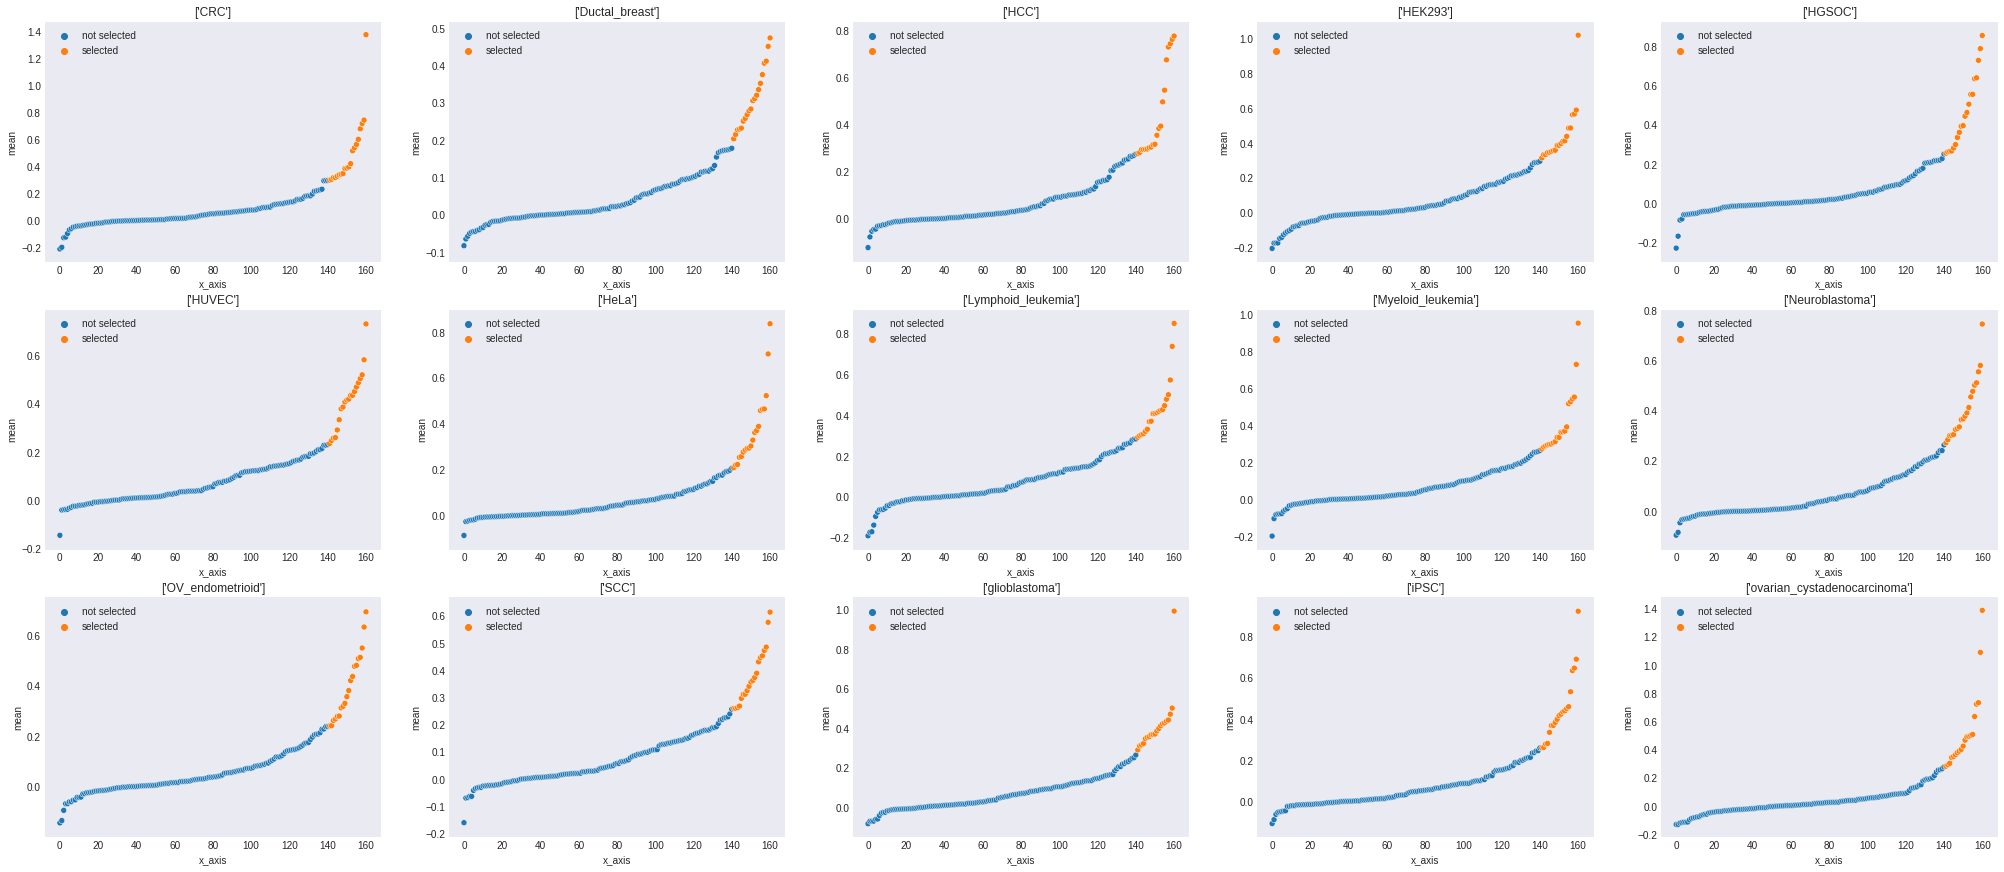

In [48]:
rank_plot_shap(shap_values_lr_test, y_lr_correct, color=True, top_n=20)

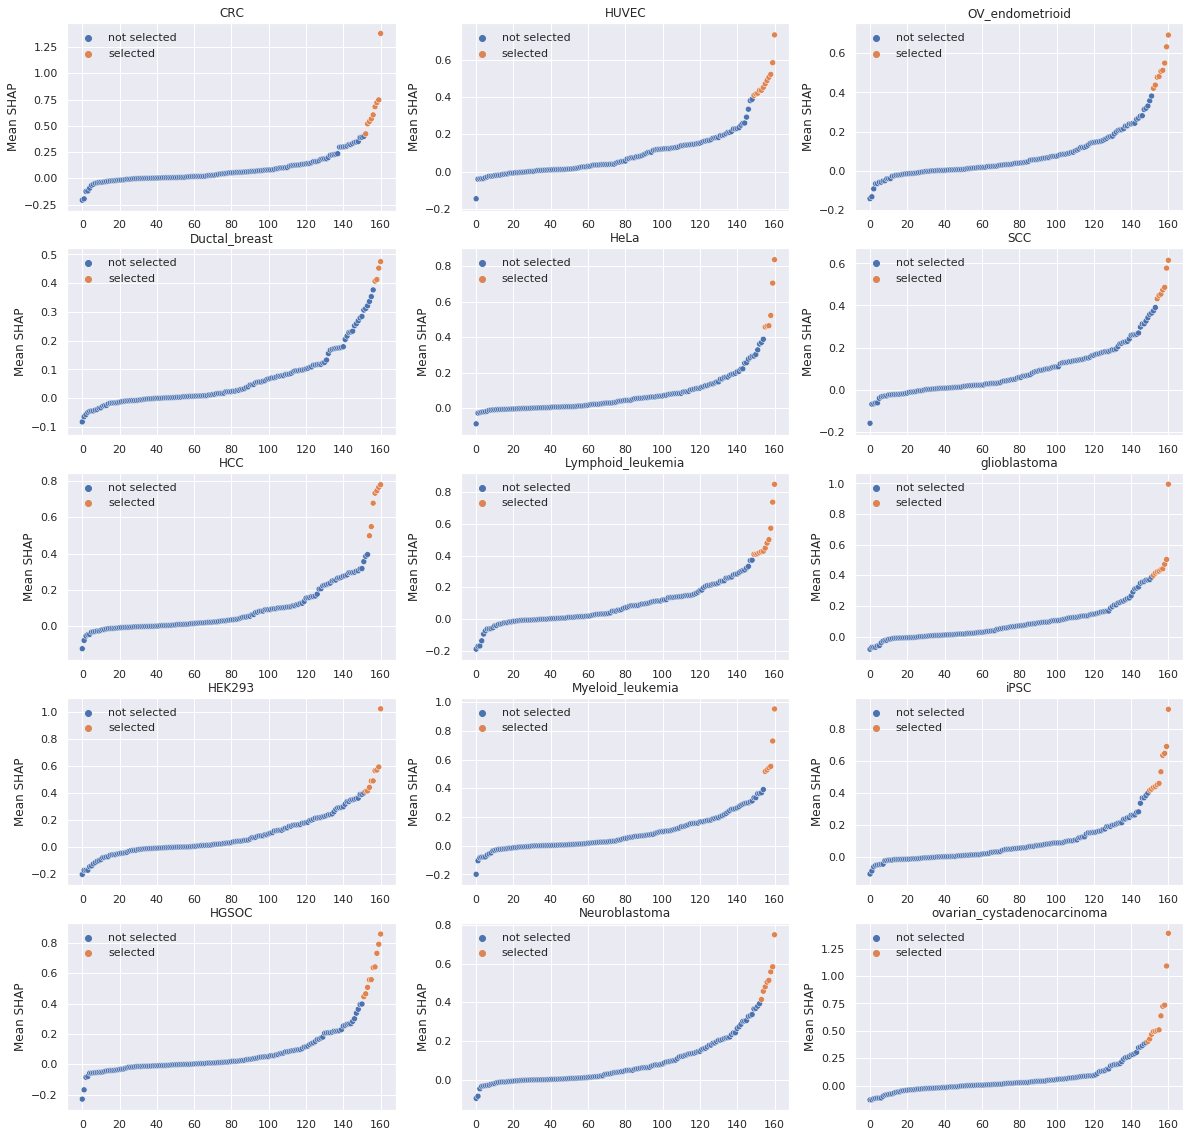

In [29]:
rank_plot_shap(shap_lr_test, y_lr_correct, color=True, threshold=.4)

In [126]:
shaps_df = pd.DataFrame(shap_lr_test[2], columns=features)

# Create dataframe with mean and std of the shap values for the test_samples corresponding to that class 
test = pd.DataFrame(shaps_df.loc[y_lr_correct ==2,:].mean(), columns = ["mean"])

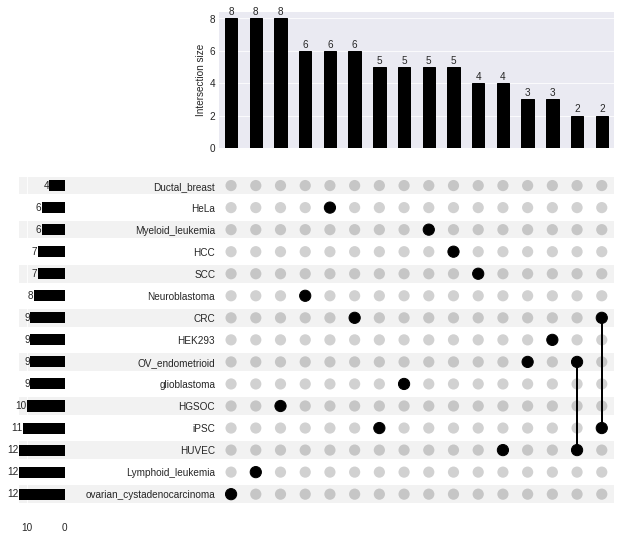

In [45]:
class_proteins_lr, _ = get_stats_shap_threshold(shap_lr_test, y_lr_correct, threshold=.4, return_by_list=False)
upset_cp_pos = uplt.from_contents(class_proteins_lr)
uplt.UpSet(upset_cp_pos, show_counts=True, sort_by="cardinality", min_subset_size=2)

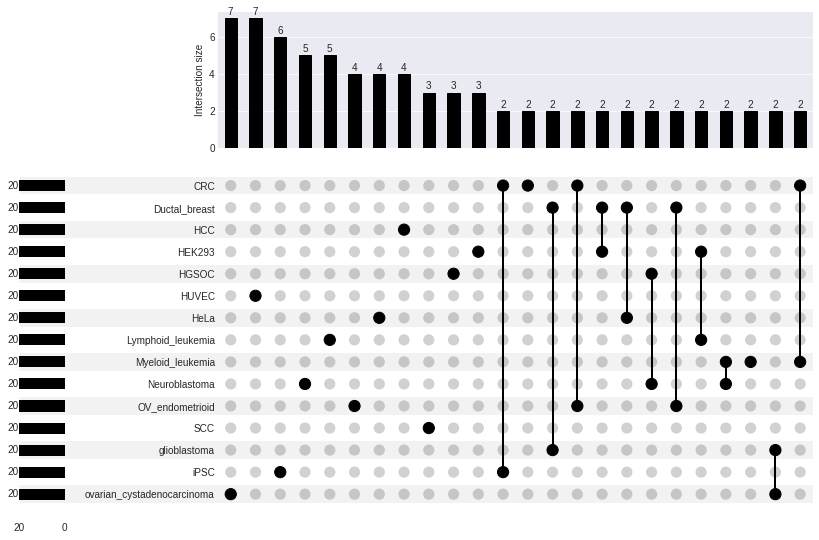

In [78]:
class_proteins_lr, _ = get_stats_shap_threshold(shap_values_lr_test, y_lr_correct, top_n=20, return_by_list=False)
upset_cp_pos = uplt.from_contents(class_proteins_lr)
uplt.UpSet(upset_cp_pos, show_counts=True, sort_by="cardinality", min_subset_size=2)

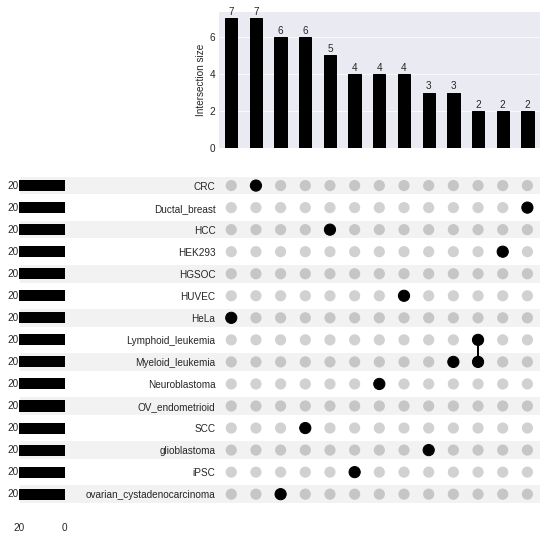

In [79]:
class_proteins_rf, _ = get_stats_shap_threshold(shap_values_rf_test, y_rf_correct, top_n=20, return_by_list=False)
upset_cp_pos = uplt.from_contents(class_proteins_rf)
uplt.UpSet(upset_cp_pos, show_counts=True, sort_by="cardinality", min_subset_size=2)

---

See the overlap of most important proteins for classification between classifiers

In [ ]:
overlap_df = {"Group": [], "uniprot_id": [], "description": []}

for n in class_proteins_lr.keys():

    for prot in set(class_proteins_lr[n]).intersection(set(class_proteins_rf[n])):
        overlap_df["Group"].append(n)
        overlap_df["uniprot_id"].append(prot)
        overlap_df["description"].append(uniprot_description.loc[prot][0])

In [83]:
pd.DataFrame(overlap_df)

Group uniprot_id                        description
0                           CRC     P27105                          Stomatin 
1                           CRC     P62877  E3 ubiquitin-protein ligase RBX1 
2                           CRC     P16144                   Integrin beta-4 
3                           CRC     Q14151     Scaffold attachment factor B2 
4                           CRC     Q16352                  Alpha-internexin 
..                          ...        ...                                ...
113  ovarian_cystadenocarcinoma     P14923              Junction plakoglobin 
114  ovarian_cystadenocarcinoma     P11766     Alcohol dehydrogenase class-3 
115  ovarian_cystadenocarcinoma     Q9UJC3            Protein Hook homolog 1 
116  ovarian_cystadenocarcinoma     Q14126                      Desmoglein-2 
117  ovarian_cystadenocarcinoma     Q8IVF2                     Protein AHNAK2

[118 rows x 3 columns]

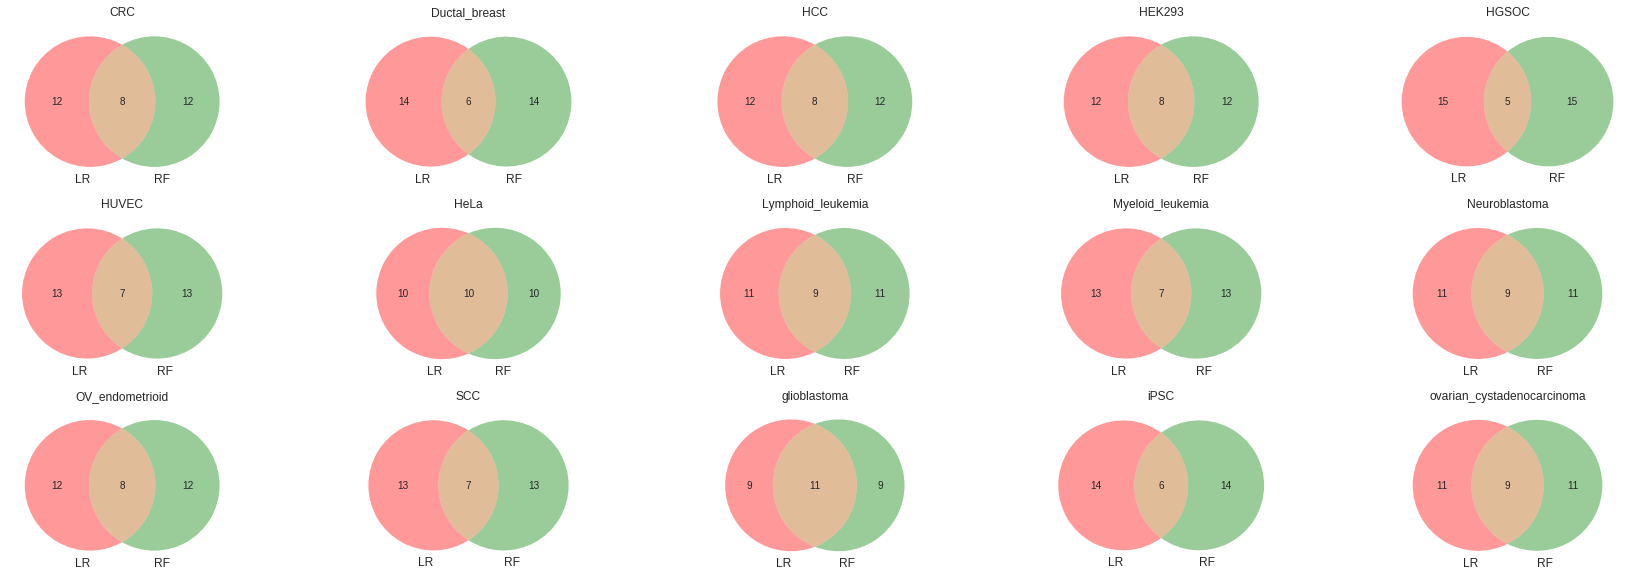

In [84]:
fig, ((ax1,ax2,ax3,ax4,ax5), (ax6,ax7,ax8,ax9,ax10), (ax11,ax12,ax13,ax14,ax15)) = plt.subplots(3,5,figsize=(30,10))

axes = [ax1,ax2,ax3,ax4,ax5, ax6,ax7,ax8,ax9,ax10, ax11,ax12,ax13,ax14,ax15]
for i in range(15):
    class_name = target_encoder.inverse_transform([i])[0]

    lr_features = set(class_proteins_lr[class_name])
    #svc_features = set(class_proteins_svc_pos[class_name])
    rf_features = set(class_proteins_rf[class_name])

    axes[i].set_title(class_name)
    venn.venn2(subsets = (lr_features, rf_features), set_labels = ('LR', 'RF'), ax=axes[i])

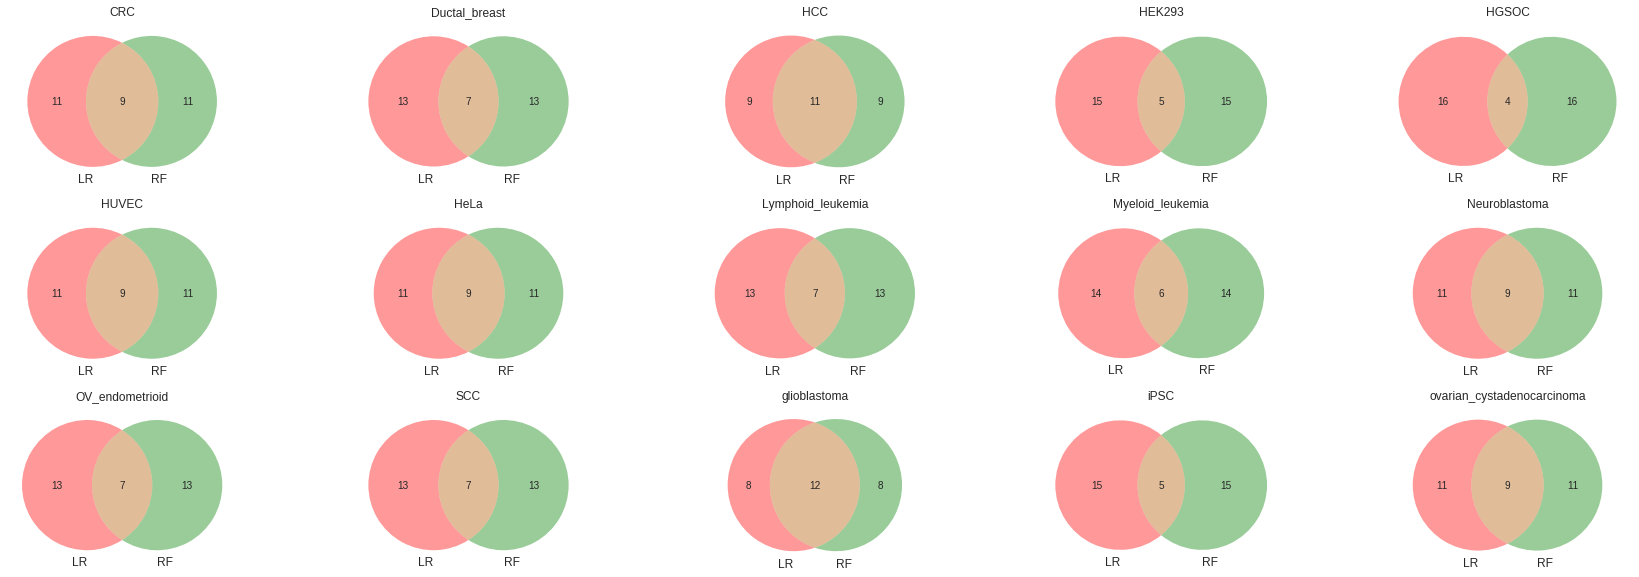

In [190]:
fig, ((ax1,ax2,ax3,ax4,ax5), (ax6,ax7,ax8,ax9,ax10), (ax11,ax12,ax13,ax14,ax15)) = plt.subplots(3,5,figsize=(30,10))

axes = [ax1,ax2,ax3,ax4,ax5, ax6,ax7,ax8,ax9,ax10, ax11,ax12,ax13,ax14,ax15]
for i in range(15):
    class_name = target_encoder.inverse_transform([i])[0]

    lr_features = set(class_proteins_lr[class_name])
    #svc_features = set(class_proteins_svc_pos[class_name])
    rf_features = set(class_proteins_rf[class_name])

    axes[i].set_title(class_name)
    venn.venn2(subsets = (lr_features, rf_features), set_labels = ('LR', 'RF'), ax=axes[i])

---

In [8]:
abundance_df = pd.DataFrame(index=features)
abundance_df_std = pd.DataFrame(index=features)

for i in range(15):

    abundance_df[target_encoder.inverse_transform([i])[0] + '_mean'] = pd.DataFrame(x_lr_correct, columns=features).loc[y_lr_correct == i,:].mean()
    abundance_df_std[target_encoder.inverse_transform([i])[0] + '_std'] = pd.DataFrame(x_lr_correct, columns=features).loc[y_lr_correct == i,:].std()
rank_df = abundance_df.rank(axis=1).rename(columns={x+"_mean":x+"_rank" for x in target_encoder.inverse_transform(range(15))})

In [9]:
def get_summary_df(label, shaps, y, top_n=False, ranked=False, thresholding=False, threshold_std=1.96, keep_only_enriched=False, hard_threshold=False):    
    
    shaps_df = pd.DataFrame(shaps[label], columns=features)

    if ranked:
        stat_shaps_df = pd.DataFrame(shaps_df.loc[y == label,:].mean(), columns = ["SHAP_mean"]).rank()
    else:
        stat_shaps_df = pd.DataFrame(shaps_df.loc[y == label,:].mean(), columns = ["SHAP_mean"])
    stat_shaps_df["Abundance_rank"] = rank_df[target_encoder.inverse_transform([label])[0]+"_rank"]
    stat_shaps_df["Abundance_mean"] = abundance_df.loc[:,target_encoder.inverse_transform([label])[0]+'_mean']
    stat_shaps_df["Abundance_std"] = abundance_df_std.loc[:,target_encoder.inverse_transform([label])[0]+'_std']
    stat_shaps_df["description"] = uniprot_description.loc[stat_shaps_df.index,"description"]
    
    
    if top_n:
        stat_shaps_df = stat_shaps_df.sort_values("SHAP_mean", ascending=False)[:top_n]
        stat_shaps_df = stat_shaps_df[:top_n]
        
        
    if hard_threshold:
        stat_shaps_df = stat_shaps_df.loc[stat_shaps_df.index[stat_shaps_df["SHAP_mean"] > hard_threshold],:]

    if thresholding:
        mean_of_means, std_of_means = stat_shaps_df["SHAP_mean"].mean(), stat_shaps_df["SHAP_mean"].std()
        threshold_pos = mean_of_means + threshold_std*std_of_means

        stat_shaps_df = stat_shaps_df.loc[stat_shaps_df.index[stat_shaps_df["SHAP_mean"] > threshold_pos],:]

    if keep_only_enriched:
        stat_shaps_df = stat_shaps_df.loc[stat_shaps_df.index[stat_shaps_df["Abundance_rank"] >= 8],:]

    return stat_shaps_df

In [146]:
get_summary_df(target_encoder.transform(["CRC"])[0], shap_lr_test, y_lr_correct, top_n=161).loc["Q16352".split()]

SHAP_mean  Abundance_rank  Abundance_mean  Abundance_std  \
Q16352   0.298884             1.0        0.172066       0.073631   

              description  
Q16352  Alpha-internexin

In [140]:
target_encoder.inverse_transform(np.unique(targets))

array(['CRC', 'Ductal_breast', 'HCC', 'HEK293', 'HGSOC', 'HUVEC', 'HeLa',
       'Lymphoid_leukemia', 'Myeloid_leukemia', 'Neuroblastoma',
       'OV_endometrioid', 'SCC', 'glioblastoma', 'iPSC',
       'ovarian_cystadenocarcinoma'], dtype=object)

In [156]:
all.loc["P32004"]

SHAP_mean  Abundance_rank  Abundance_mean  Abundance_std  \
P32004   0.124763             6.0        0.212178       0.171757   
P32004  -0.009327             9.0        0.366603       0.238795   
P32004   0.033571             7.0        0.214063       0.014594   
P32004   0.181989             3.0        0.163598       0.111731   
P32004   0.300427            13.0        0.589328       0.269818   
P32004   0.142296             4.0        0.183560       0.061103   
P32004   0.173694            12.0        0.555515       0.305383   
P32004   0.018138             5.0        0.195977       0.033315   
P32004   0.103004             1.0        0.095775       0.066442   
P32004   0.513148            15.0        0.679323       0.113634   
P32004  -0.006653            10.0        0.367070       0.224224   
P32004   0.078465            14.0        0.597910       0.297298   
P32004   0.027978             2.0        0.161100       0.055478   
P32004   0.004028             8.0        0.307479       0.044822   
P32004  -0.037567            11.0        0.467286       0.428686   

                              description  SHAP_rank  \
P32004  Neural cell adhesion molecule L1        47.0   
P32004  Neural cell adhesion molecule L1       137.0   
P32004  Neural cell adhesion molecule L1        83.0   
P32004  Neural cell adhesion molecule L1        40.0   
P32004  Neural cell adhesion molecule L1        15.0   
P32004  Neural cell adhesion molecule L1        49.0   
P32004  Neural cell adhesion molecule L1        28.0   
P32004  Neural cell adhesion molecule L1       102.0   
P32004  Neural cell adhesion molecule L1        59.0   
P32004  Neural cell adhesion molecule L1         4.0   
P32004  Neural cell adhesion molecule L1       133.0   
P32004  Neural cell adhesion molecule L1        74.0   
P32004  Neural cell adhesion molecule L1       102.0   
P32004  Neural cell adhesion molecule L1       122.0   
P32004  Neural cell adhesion molecule L1       139.0   

                             Group  
P32004                         CRC  
P32004               Ductal_breast  
P32004                         HCC  
P32004                      HEK293  
P32004                       HGSOC  
P32004                       HUVEC  
P32004                        HeLa  
P32004           Lymphoid_leukemia  
P32004            Myeloid_leukemia  
P32004               Neuroblastoma  
P32004             OV_endometrioid  
P32004                         SCC  
P32004                glioblastoma  
P32004                        iPSC  
P32004  ovarian_cystadenocarcinoma

In [155]:
all.loc["A0MZ66"]

SHAP_mean  Abundance_rank  Abundance_mean  Abundance_std description  \
A0MZ66   0.056825            11.0        0.677046       0.152814  Shootin-1    
A0MZ66  -0.033444            14.0        0.714215       0.222307  Shootin-1    
A0MZ66   0.001888             6.0        0.526669       0.111806  Shootin-1    
A0MZ66  -0.125144             5.0        0.487633       0.182898  Shootin-1    
A0MZ66   0.008473             9.0        0.618604       0.261408  Shootin-1    
A0MZ66  -0.005459             8.0        0.579273       0.054756  Shootin-1    
A0MZ66  -0.005160            13.0        0.709382       0.129501  Shootin-1    
A0MZ66   0.447858             2.0        0.217610       0.081048  Shootin-1    
A0MZ66  -0.012181             4.0        0.361668       0.075603  Shootin-1    
A0MZ66   0.582916             1.0        0.157790       0.089130  Shootin-1    
A0MZ66   0.026077            10.0        0.649596       0.292899  Shootin-1    
A0MZ66   0.032122            15.0        0.789562       0.041209  Shootin-1    
A0MZ66   0.348579             3.0        0.292398       0.101688  Shootin-1    
A0MZ66   0.015345             7.0        0.547757       0.057003  Shootin-1    
A0MZ66   0.025140            12.0        0.697284       0.213426  Shootin-1    

        SHAP_rank                       Group  
A0MZ66       77.0                         CRC  
A0MZ66      151.0               Ductal_breast  
A0MZ66      120.0                         HCC  
A0MZ66      155.0                      HEK293  
A0MZ66       93.0                       HGSOC  
A0MZ66      140.0                       HUVEC  
A0MZ66      146.0                        HeLa  
A0MZ66        6.0           Lymphoid_leukemia  
A0MZ66      139.0            Myeloid_leukemia  
A0MZ66        2.0               Neuroblastoma  
A0MZ66       92.0             OV_endometrioid  
A0MZ66       92.0                         SCC  
A0MZ66       16.0                glioblastoma  
A0MZ66      107.0                        iPSC  
A0MZ66       83.0  ovarian_cystadenocarcinoma

In [27]:
target_encoder.inverse_transform([0])

array(['CRC'], dtype=object)

In [10]:
all=pd.DataFrame()
for i in range(15):
    summaries_lr = get_summary_df(i, shap_lr_test, y_lr_correct, top_n=161).sort_index()
  
    summaries_lr["SHAP_rank"]=summaries_lr["SHAP_mean"].rank(ascending=False)
    summaries_lr["Group"] = target_encoder.inverse_transform([i])[0]
    summaries_lr=summaries_lr.sort_values(by="SHAP_rank", ascending=True)

    all = pd.concat([all, summaries_lr])

In [12]:
all.to_csv("all_feature_importances.csv")

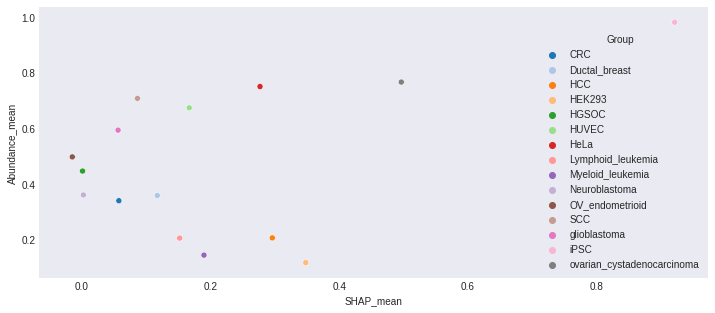

In [143]:
plt.figure(figsize=(12,5))
sns.scatterplot(data=all.loc["O00592"], x="SHAP_mean", y="Abundance_mean", hue="Group", palette=sns.color_palette("tab20")[:15])

In [115]:
top20=pd.DataFrame()
for i in range(15):
    summaries_lr = get_summary_df(i, shap_lr_test, y_lr_correct, top_n=20).sort_index()
  
    summaries_lr["SHAP_rank"]=summaries_lr["SHAP_mean"].rank(ascending=False)
    summaries_lr["Group"] = target_encoder.inverse_transform([i])[0]
    summaries_lr=summaries_lr.sort_values(by="SHAP_rank", ascending=True)

    top20 = pd.concat([top20, summaries_lr])

In [117]:
top20_abundant = top20[top20.Abundance_rank > 8]

In [154]:
top20[top20.Group == "SCC"]

SHAP_mean  Abundance_rank  Abundance_mean  Abundance_std  \
Q14116   0.614952            15.0        0.945495       0.035602   
Q6WKZ4   0.577588            15.0        0.854540       0.133870   
Q9NZN4   0.486411            14.0        0.851614       0.068865   
Q8TBX8   0.473850            15.0        0.891492       0.116688   
P19174   0.454022             2.0        0.130807       0.068957   
Q9UIQ6   0.448006             2.0        0.233103       0.029131   
Q92616   0.431838             1.0        0.235168       0.214579   
Q9UKN8   0.390271             5.0        0.223221       0.189466   
Q8WUF5   0.374584            15.0        0.872421       0.186583   
Q9NS86   0.363911            15.0        0.833656       0.259650   
Q9BZQ8   0.357980            14.0        0.885978       0.063214   
Q8IWE2   0.342022            14.0        0.870459       0.038113   
Q9NTX5   0.326110             2.0        0.200412       0.144416   
P20700   0.312842             1.0        0.145318       0.122875   
P16144   0.312671            15.0        0.740303       0.114290   
Q08211   0.297583             2.0        0.198052       0.205630   
Q8TEM1   0.269369             2.0        0.210713       0.154831   
P27105   0.263374             3.0        0.222683       0.029155   
P48681   0.260911             2.0        0.161983       0.102420   
Q15029   0.260744             2.0        0.248463       0.126529   

                                              description  SHAP_rank Group  
Q14116                                    Interleukin-18         1.0   SCC  
Q6WKZ4                Rab11 family-interacting protein 1         2.0   SCC  
Q9NZN4                    EH domain-containing protein 2         3.0   SCC  
Q8TBX8  Phosphatidylinositol 5-phosphate 4-kinase type...        4.0   SCC  
P19174  1-phosphatidylinositol 4,5-bisphosphate phosph...        5.0   SCC  
Q9UIQ6                    Leucyl-cystinyl aminopeptidase         6.0   SCC  
Q92616                 eIF-2-alpha kinase activator GCN1         7.0   SCC  
Q9UKN8     General transcription factor 3C polypeptide 4         8.0   SCC  
Q8WUF5                         RelA-associated inhibitor         9.0   SCC  
Q9NS86                               LanC-like protein 2        10.0   SCC  
Q9BZQ8                                   Protein Niban 1        11.0   SCC  
Q8IWE2                                    Protein NOXP20        12.0   SCC  
Q9NTX5                    Ethylmalonyl-CoA decarboxylase        13.0   SCC  
P20700                                           Lamin-B1       14.0   SCC  
P16144                                   Integrin beta-4        15.0   SCC  
Q08211                      ATP-dependent RNA helicase A        16.0   SCC  
Q8TEM1            Nuclear pore membrane glycoprotein 210        17.0   SCC  
P27105                                          Stomatin        18.0   SCC  
P48681                                             Nestin       19.0   SCC  
Q15029  116 kDa U5 small nuclear ribonucleoprotein com...       20.0   SCC

In [121]:
top20_abundant.to_csv("top20_abundant.csv")

In [23]:
y_lr_correct

array([ 4,  4,  0,  0,  1, 13,  9,  1,  1,  1, 12,  9, 10,  8,  3,  1,  1,
        6,  3,  1,  1, 12, 14,  1,  6,  4, 11,  5,  9,  5,  9,  0, 14,  6,
        1, 10,  9,  6,  6, 12, 10,  5,  0,  8,  6,  1,  7,  0,  9, 13, 10,
        4,  0, 10,  0,  2,  2,  0,  7,  0,  4,  0,  4,  1,  1,  8,  0,  4,
        4,  9,  1,  0,  9,  6, 11,  5,  9, 12, 11,  6,  0, 11,  1,  3,  1,
        0,  0,  6,  1, 11,  6,  9,  0, 12, 13,  1,  1,  5,  1, 13,  8,  6,
        6])

In [100]:
summary_abundance = pd.DataFrame(x_lr_correct, columns=feature_names).loc[:,all.index.unique()]

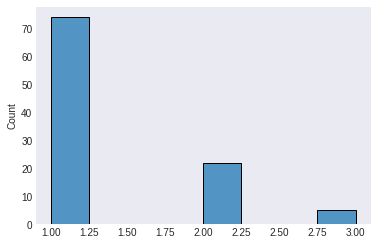

In [50]:
sns.histplot(all.index.value_counts())

In [51]:
index_counts = all.index.value_counts()

In [53]:
protein_labels = all.reset_index().apply(lambda x: "Shared" if index_counts[x["index"]] > 1 else x.Group, axis=1)

In [62]:
colors = sns.color_palette("tab20")[:16]
color_map = {x: colors[i] for i,x in enumerate(protein_labels.unique())}

In [82]:
type_color = pd.concat([protein_labels, protein_labels.apply(lambda x: color_map[x]), pd.Series(all.index)],axis=1).rename(columns={0: "Label", 1: "color", 2:"uniprot_id"})

In [87]:
type_color = type_color.loc[type_color.uniprot_id.drop_duplicates().index]

In [ ]:
from matplotlib.patches import Patch

handles = [Patch(facecolor=lut[name]) for name in lut]
plt.legend(handles, lut, title='Species',
           bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')

In [92]:
type_color

Label  \
0                        Shared   
1                           CRC   
2                        Shared   
3                           CRC   
4                        Shared   
..                          ...   
126  ovarian_cystadenocarcinoma   
127  ovarian_cystadenocarcinoma   
128  ovarian_cystadenocarcinoma   
129  ovarian_cystadenocarcinoma   
131  ovarian_cystadenocarcinoma   

                                                 color uniprot_id  
0    (0.12156862745098039, 0.4666666666666667, 0.70...     P62877  
1    (0.6823529411764706, 0.7803921568627451, 0.909...     Q9UDT6  
2    (0.12156862745098039, 0.4666666666666667, 0.70...     Q9BWF3  
3    (0.6823529411764706, 0.7803921568627451, 0.909...     Q14151  
4    (0.12156862745098039, 0.4666666666666667, 0.70...     P11388  
..                                                 ...        ...  
126  (0.7803921568627451, 0.7803921568627451, 0.780...     Q14126  
127  (0.7803921568627451, 0.7803921568627451, 0.780...     P12956  
128  (0.7803921568627451, 0.7803921568627451, 0.780...     P11766  
129  (0.7803921568627451, 0.7803921568627451, 0.780...     Q9UJC3  
131  (0.7803921568627451, 0.7803921568627451, 0.780...     Q16762  

[101 rows x 3 columns]

In [94]:
type_color[type_color.Label=="Shared"]["color"][0]

(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)

In [ ]:
summary_abundance["Group"] = target_encoder.inverse_transform(y_lr_correct)
summary_abundance = summary_abundance.groupby("Group").mean()

In [104]:
row_colors = pd.Series(target_encoder.inverse_transform(y_lr_correct))
colors = sns.color_palette("tab20")[:15]
color_map = {x: colors[i] for i,x in enumerate(row_colors.unique())}

In [106]:
row_colors.map(color_map)

0      (0.12156862745098039, 0.4666666666666667, 0.70...
1      (0.12156862745098039, 0.4666666666666667, 0.70...
2      (0.6823529411764706, 0.7803921568627451, 0.909...
3      (0.6823529411764706, 0.7803921568627451, 0.909...
4        (1.0, 0.4980392156862745, 0.054901960784313725)
                             ...                        
98       (1.0, 0.4980392156862745, 0.054901960784313725)
99        (1.0, 0.7333333333333333, 0.47058823529411764)
100         (1.0, 0.596078431372549, 0.5882352941176471)
101    (0.7725490196078432, 0.6901960784313725, 0.835...
102    (0.7725490196078432, 0.6901960784313725, 0.835...
Length: 103, dtype: object

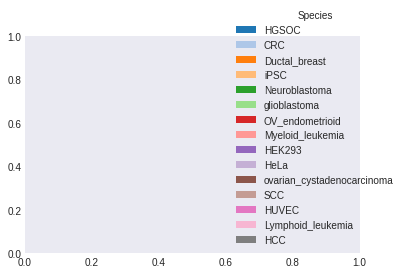

In [109]:
handles = [Patch(facecolor=color_map[name]) for name in row_colors.unique()]
plt.legend(handles, row_colors.unique(), title='Species',
           bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')

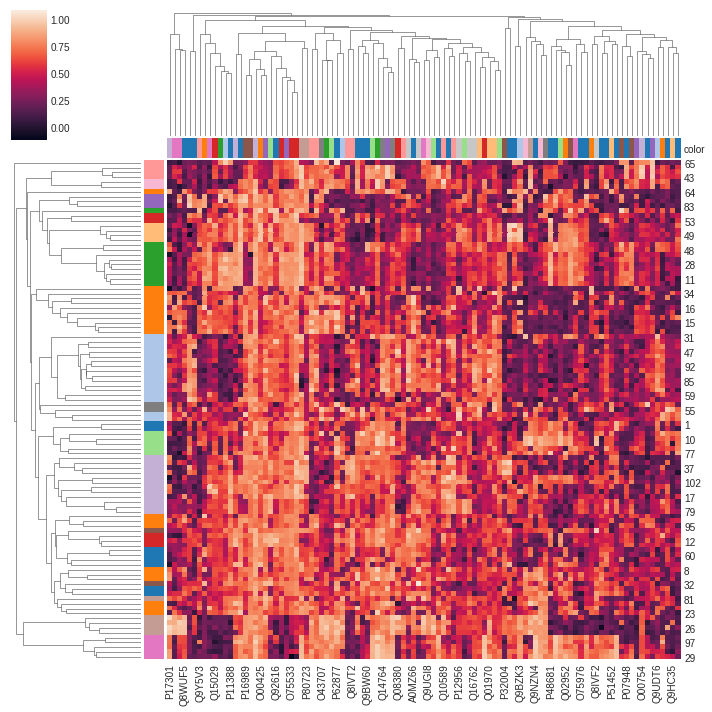

In [108]:
sns.clustermap(summary_abundance,row_colors=row_colors.map(color_map), col_colors=type_color.set_index("uniprot_id")["color"])

In [61]:
all[all.Group == "HCC"].index.tolist()

['O60701', 'P05091', 'P29218', 'P51452', 'Q01970', 'Q08J23', 'Q9HC35']

In [62]:
all.to_csv("Most_important_features_threshold_4.csv")

In [35]:
all=pd.read_csv("Most_important_features_threshold_4.csv", index_col="Unnamed: 0")

In [161]:
all[all.Group == "HCC"].sort_values(by="SHAP_rank")[:7].index.tolist()

['Q01970', 'O60701', 'P51452', 'Q08J23', 'Q9HC35', 'P05091', 'P29218']

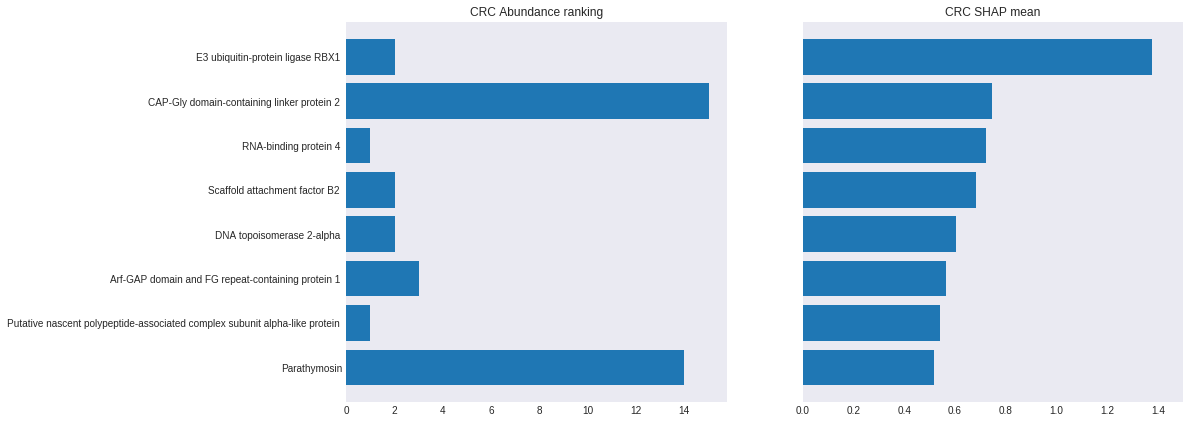

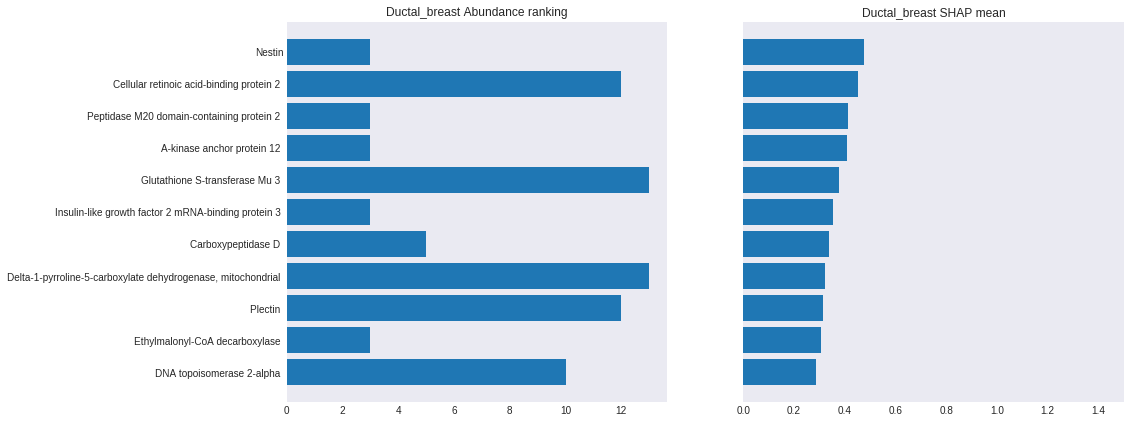

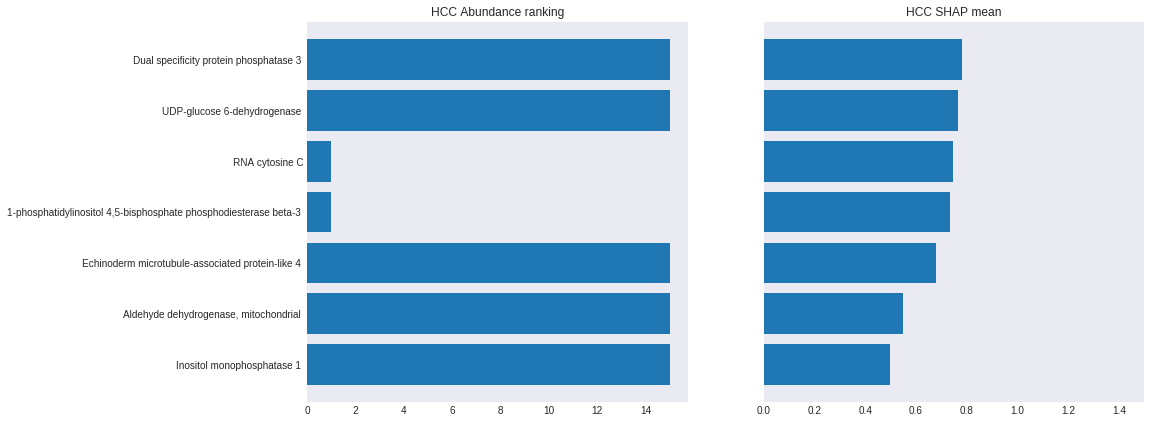

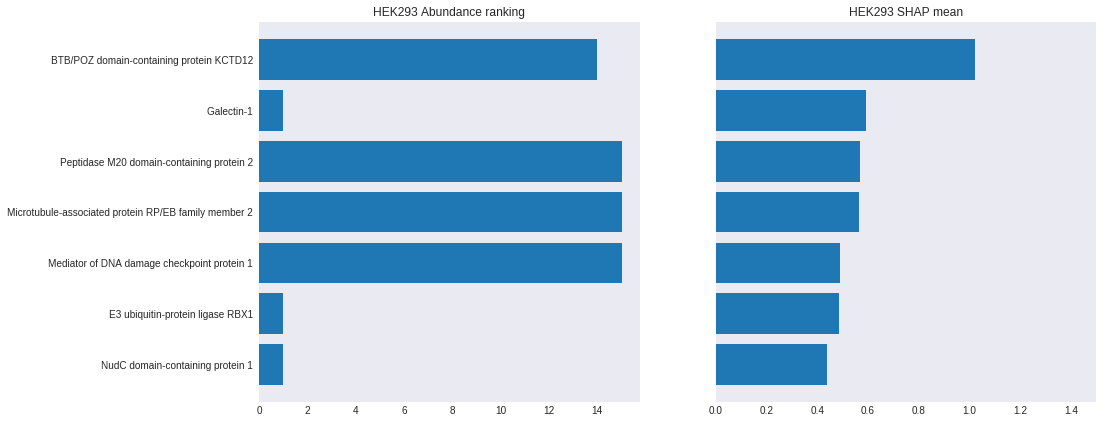

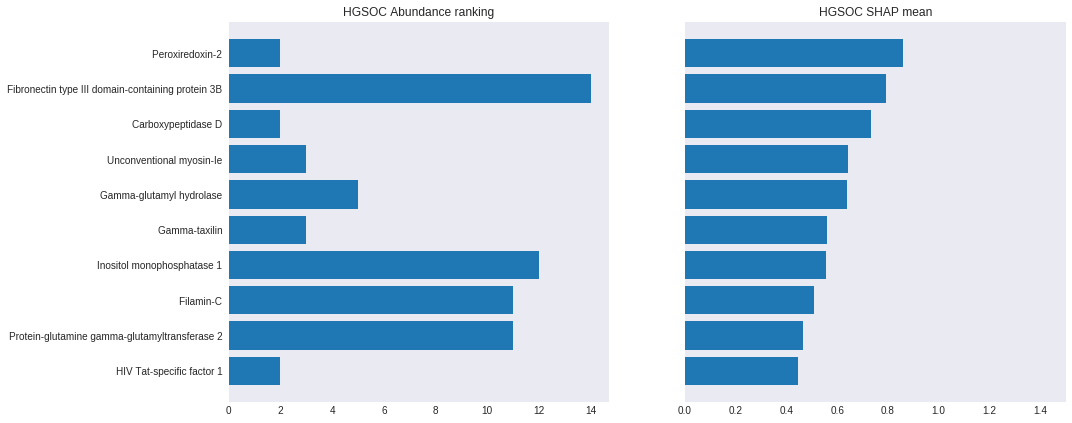

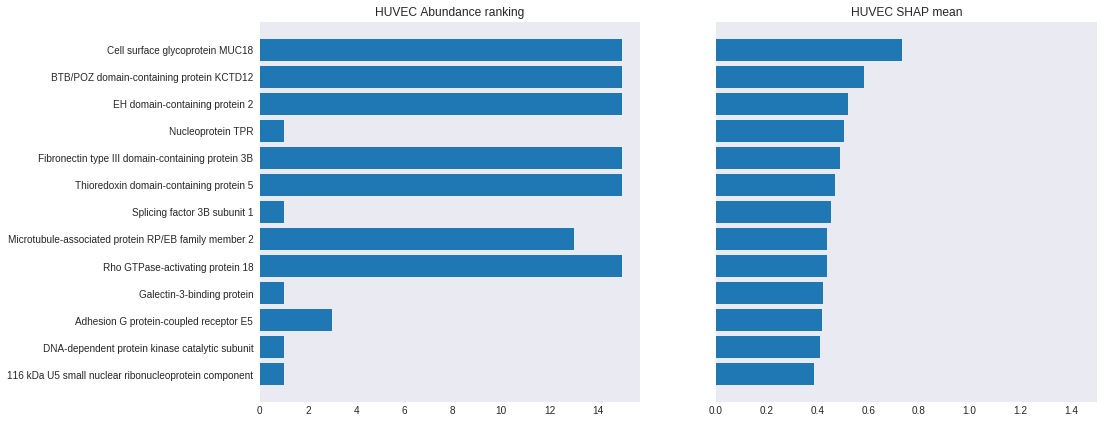

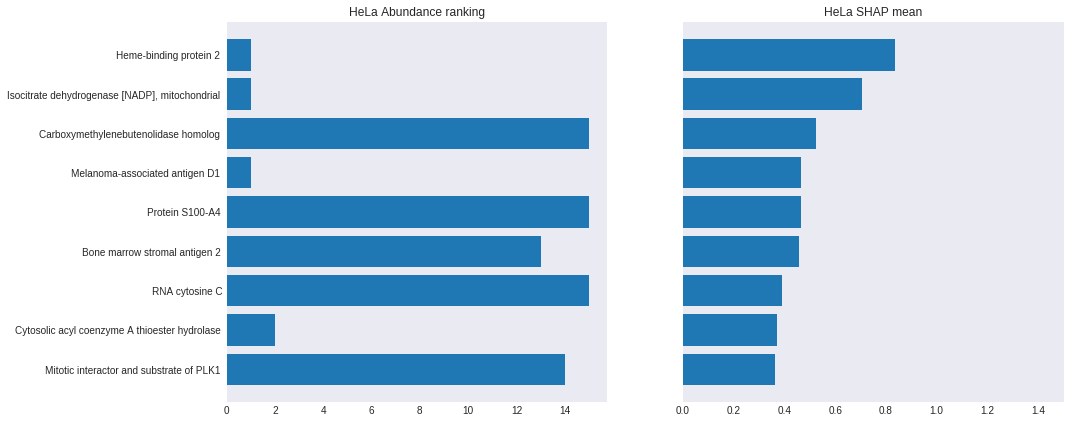

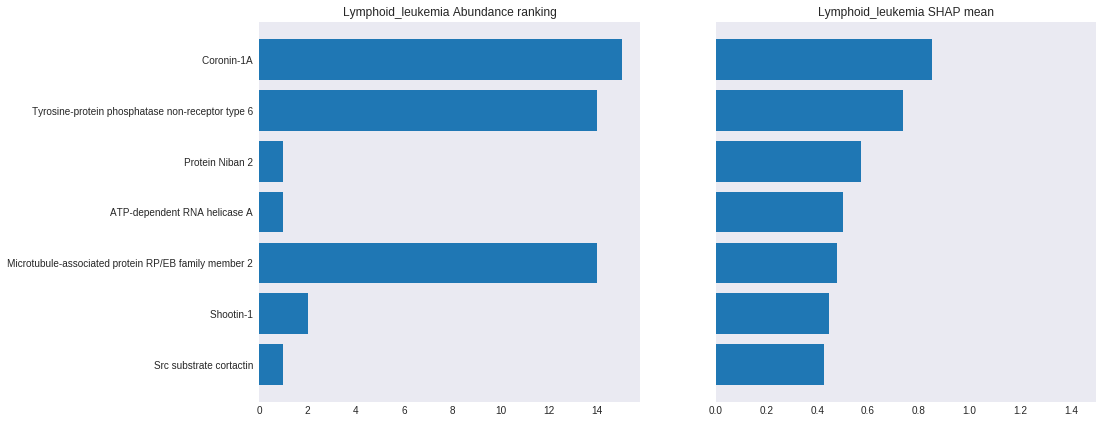

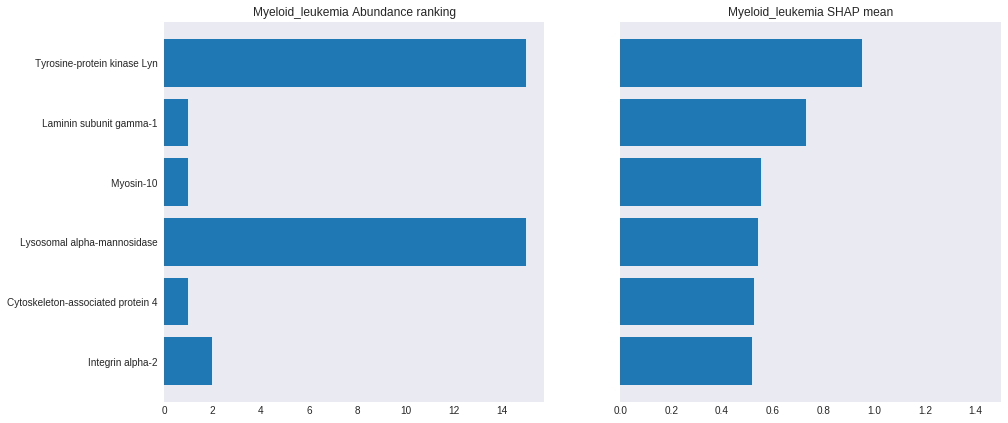

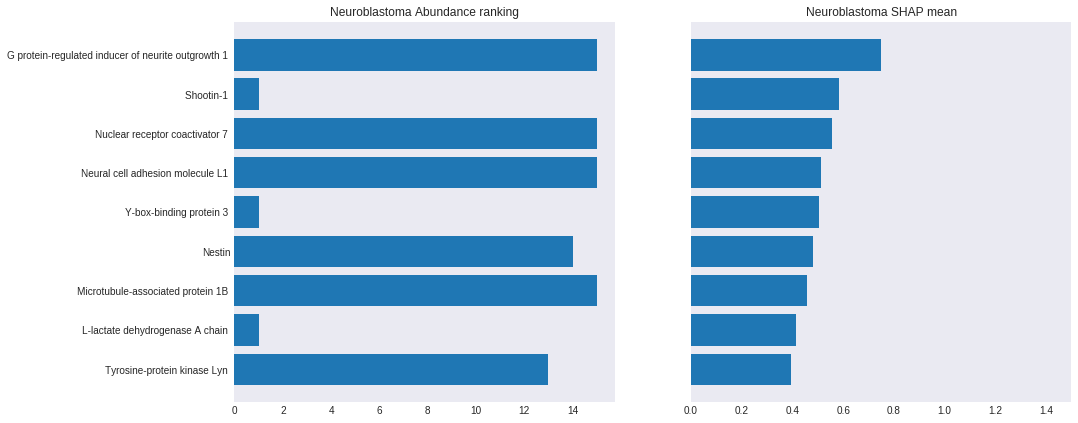

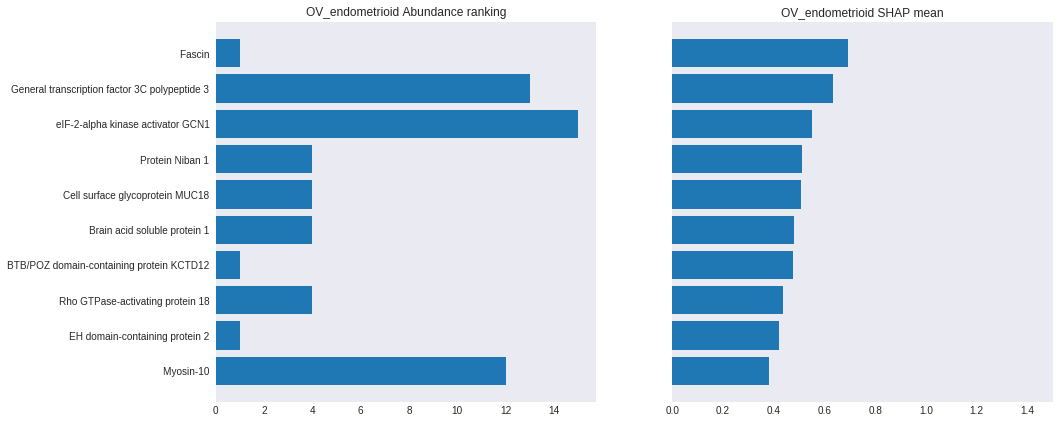

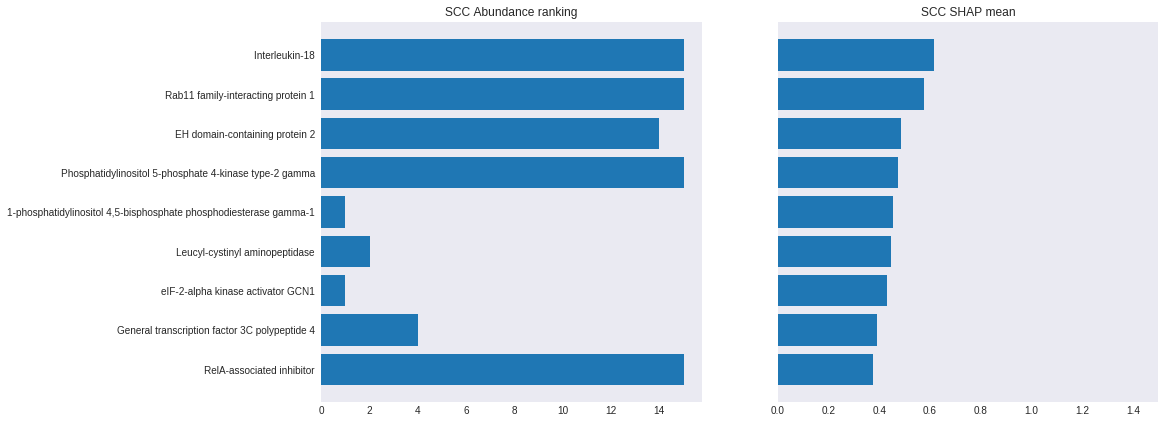

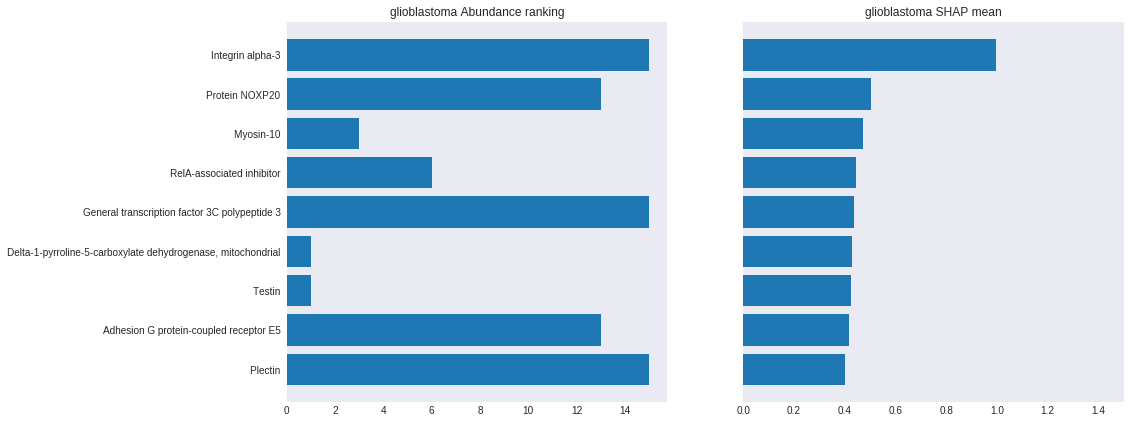

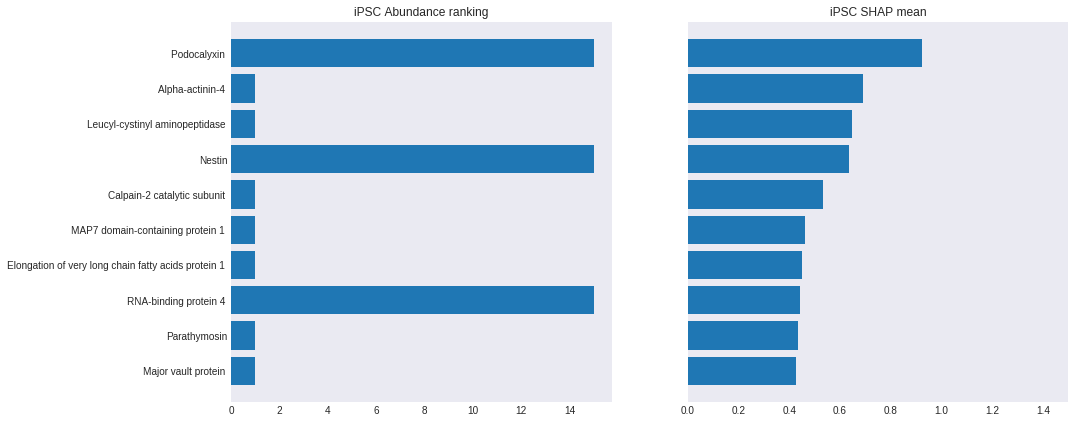

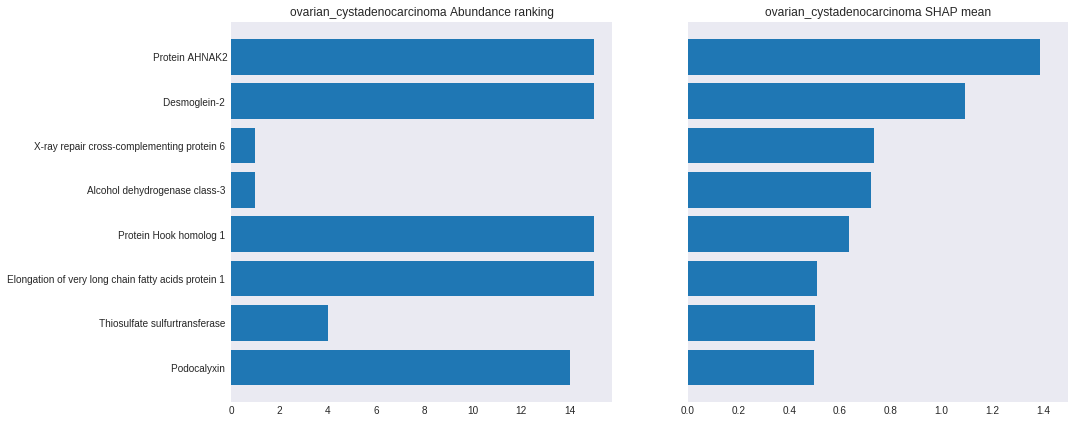

In [37]:
summaries_lr_thresh = []

for i in range(15):

    fig, ax = plt.subplots(1,2, figsize=(15,7), sharey=True)

    ax[0].barh(data = all[all.Group == target_encoder.inverse_transform([i])[0]].sort_values(by="SHAP_mean"), y = "description", width="Abundance_rank")
    ax[1].barh(data = all[all.Group == target_encoder.inverse_transform([i])[0]].sort_values(by="SHAP_mean"), y = "description", width="SHAP_mean")

    ax[1].set_ylabel(None)
    ax[1].set_xlim((0,1.5))
    ax[0].set_title(target_encoder.inverse_transform([i])[0] + " Abundance ranking")
    ax[1].set_title(target_encoder.inverse_transform([i])[0] + " SHAP mean")

---

Split important features in "depleted" and "abundant" and sum the explanations and perform GO, string and reactome

In [19]:
combined_shaps = []
prots_per_class = {}

for i in range(15):
    lr_sum = get_summary_df(i, shap_lr_test, y_lr_correct, hard_threshold=.4)
    lr_sum["model"] = "LR"
    #svc_sum = get_summary_df(i, shap_svc_train, thresholding = True)
    #svc_sum["model"] = "SVC"
    #rf_sum = get_summary_df(i, shap_rf_test, y_rf_correct, top_n=20)
    #rf_sum["model"] = "RF"

    combined_shaps.append(lr_sum) #svc_sum

    prots_per_class[target_encoder.inverse_transform([i])[0]] = combined_shaps[i].index.unique().tolist()

In [21]:
def calc_go(list_of_prots, go_type, missing_ontology):
    gos = []
    for prot in list_of_prots:
        if prot not in missing_ontology:
            gos += go_type[prot]
    go_df = {}

    renaming = {}
    for go in set(gos):
        go_df[go] = gos.count(go)

        if go in GO_description.index:
            renaming[go] = GO_description.loc[go].annotation_label

    return pd.Series(go_df).rename(index = renaming)

In [22]:
prots_per_class

{'CRC': ['P11388',
  'P16144',
  'P20962',
  'P52594',
  'P62877',
  'Q14151',
  'Q9BWF3',
  'Q9BZK3',
  'Q9UDT6'],
 'Ductal_breast': ['P29373', 'P48681', 'Q02952', 'Q8IYS1'],
 'HCC': ['O60701', 'P05091', 'P29218', 'P51452', 'Q01970', 'Q08J23', 'Q9HC35'],
 'HEK293': ['O60701',
  'P09382',
  'P62877',
  'Q14676',
  'Q15555',
  'Q8IYS1',
  'Q96CX2',
  'Q96RS6',
  'Q9BW60'],
 'HGSOC': ['O43719',
  'O75976',
  'P21980',
  'P29218',
  'P32119',
  'Q12965',
  'Q14315',
  'Q53EP0',
  'Q92820',
  'Q9NUQ3'],
 'HUVEC': ['O75533',
  'P12270',
  'P43121',
  'P48960',
  'P78527',
  'Q08380',
  'Q15555',
  'Q53EP0',
  'Q8N392',
  'Q8NBS9',
  'Q96CX2',
  'Q9NZN4'],
 'HeLa': ['P26447', 'P48735', 'Q10589', 'Q96DG6', 'Q9Y5V3', 'Q9Y5Z4'],
 'Lymphoid_leukemia': ['A0MZ66',
  'O60264',
  'P12270',
  'P29350',
  'P31146',
  'Q08211',
  'Q13151',
  'Q14247',
  'Q15555',
  'Q96TA1',
  'Q9UIQ6',
  'Q9Y5B9'],
 'Myeloid_leukemia': ['O00754',
  'P07948',
  'P11047',
  'P17301',
  'P35580',
  'Q07065'],
 'Neuroblas

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



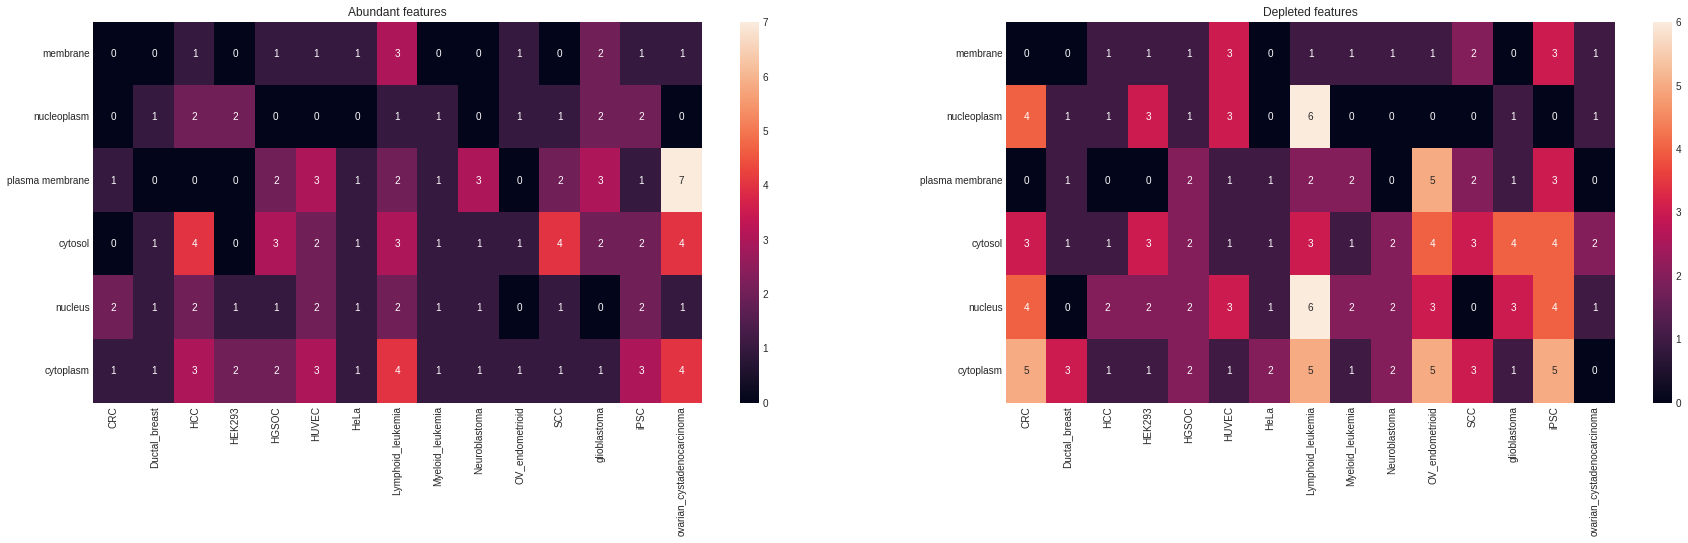

In [35]:
go_per_class_abundant = []
go_per_class_depleted = []

fig, ax = plt.subplots(1,2, figsize=(30,7))

for i, prots in prots_per_class.items():

    ind = target_encoder.transform([i])[0]
    abundant_important_features = combined_shaps[ind].loc[prots].index[combined_shaps[ind].loc[prots].Abundance_rank > 7]
    depleted_important_features = combined_shaps[ind].loc[prots].index[combined_shaps[ind].loc[prots].Abundance_rank <= 7]

    go_per_class_abundant.append(calc_go(abundant_important_features,  uniprot_go_compartment, missing_ontology_C).rename(i))
    go_per_class_depleted.append(calc_go(depleted_important_features,  uniprot_go_compartment, missing_ontology_C).rename(i))

ax[0].set_title("Abundant features")
ax[1].set_title("Depleted features")
sns.heatmap(pd.concat(go_per_class_abundant,axis=1).fillna(0).loc[["membrane", "nucleoplasm", "plasma membrane", "cytosol", "nucleus", "cytoplasm"]], ax = ax[0], annot=True)
sns.heatmap(pd.concat(go_per_class_depleted,axis=1).fillna(0).loc[["membrane", "nucleoplasm", "plasma membrane", "cytosol", "nucleus", "cytoplasm"]], ax = ax[1], annot=True)

3 6
1 3
5 2
4 5
4 6
7 5
3 3
4 8
2 4
5 3
2 7
4 3
5 4
4 7
9 3


Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



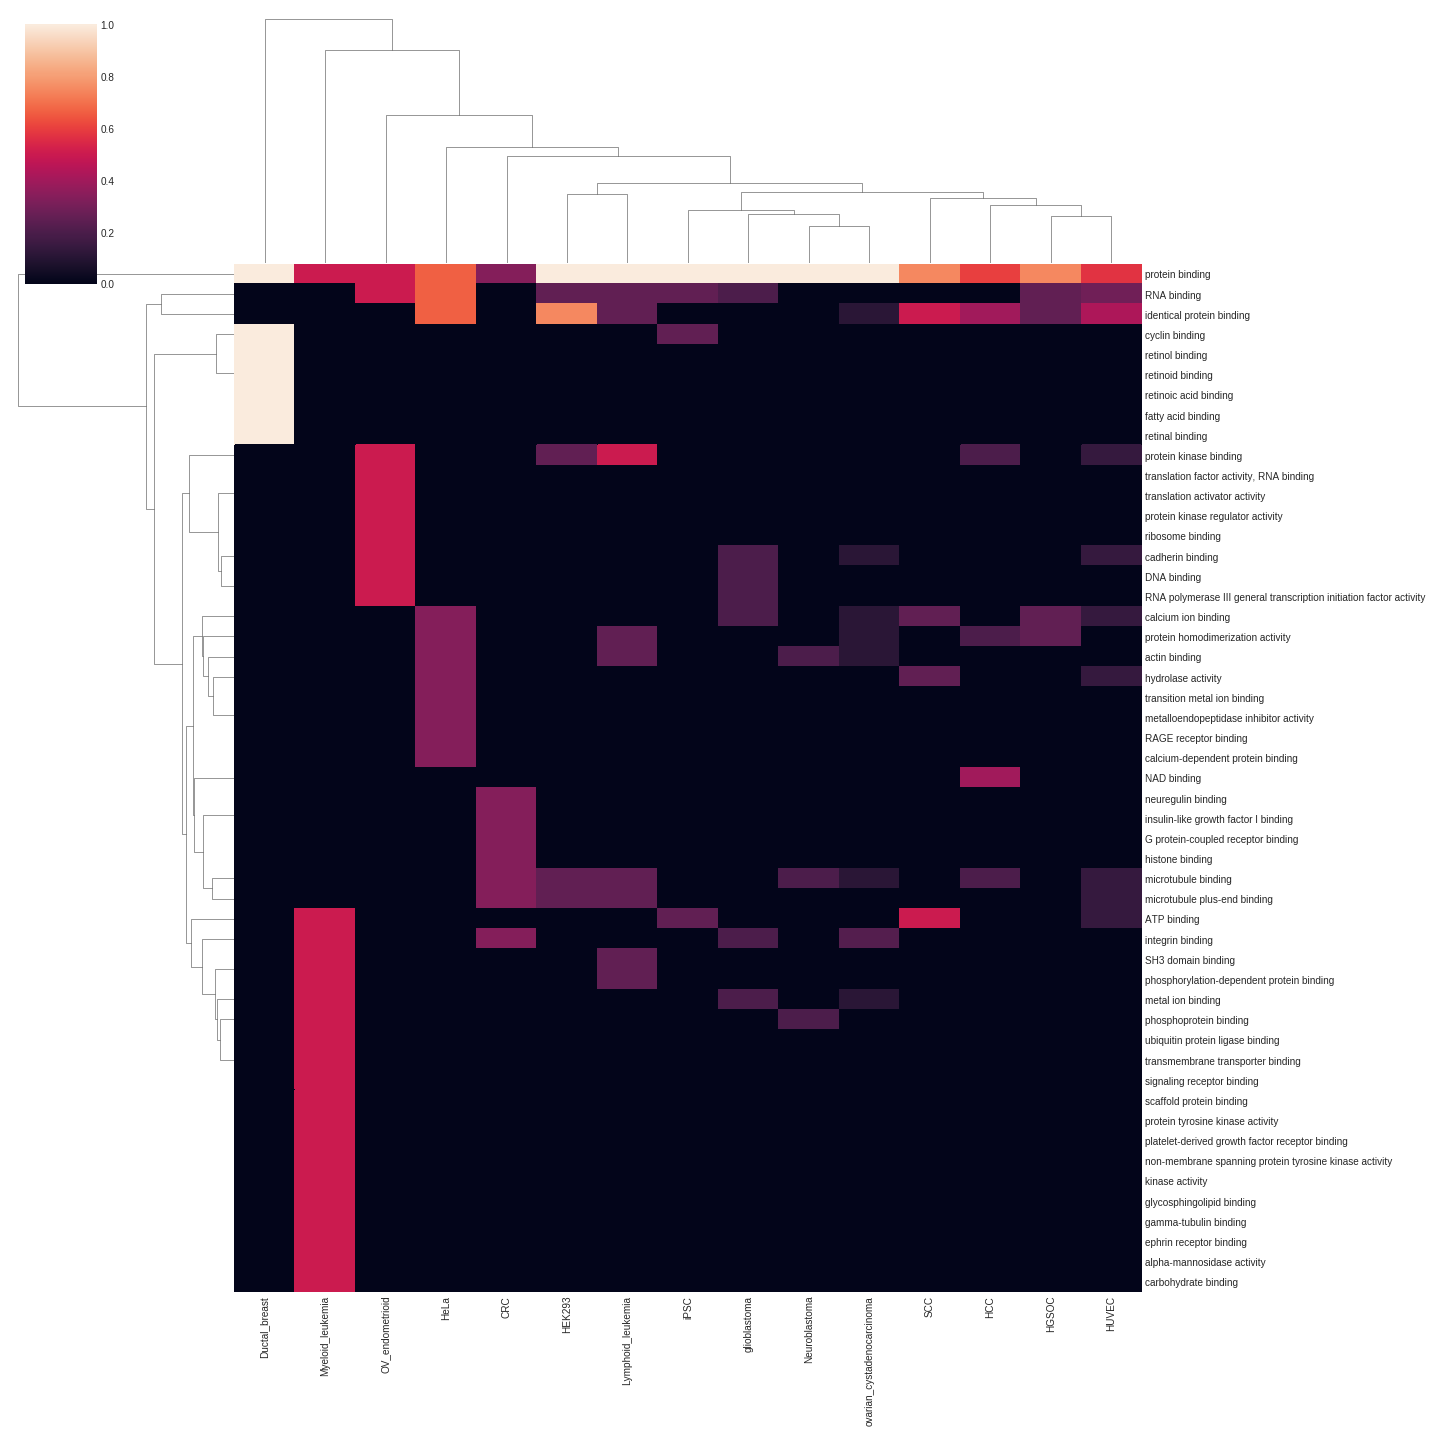

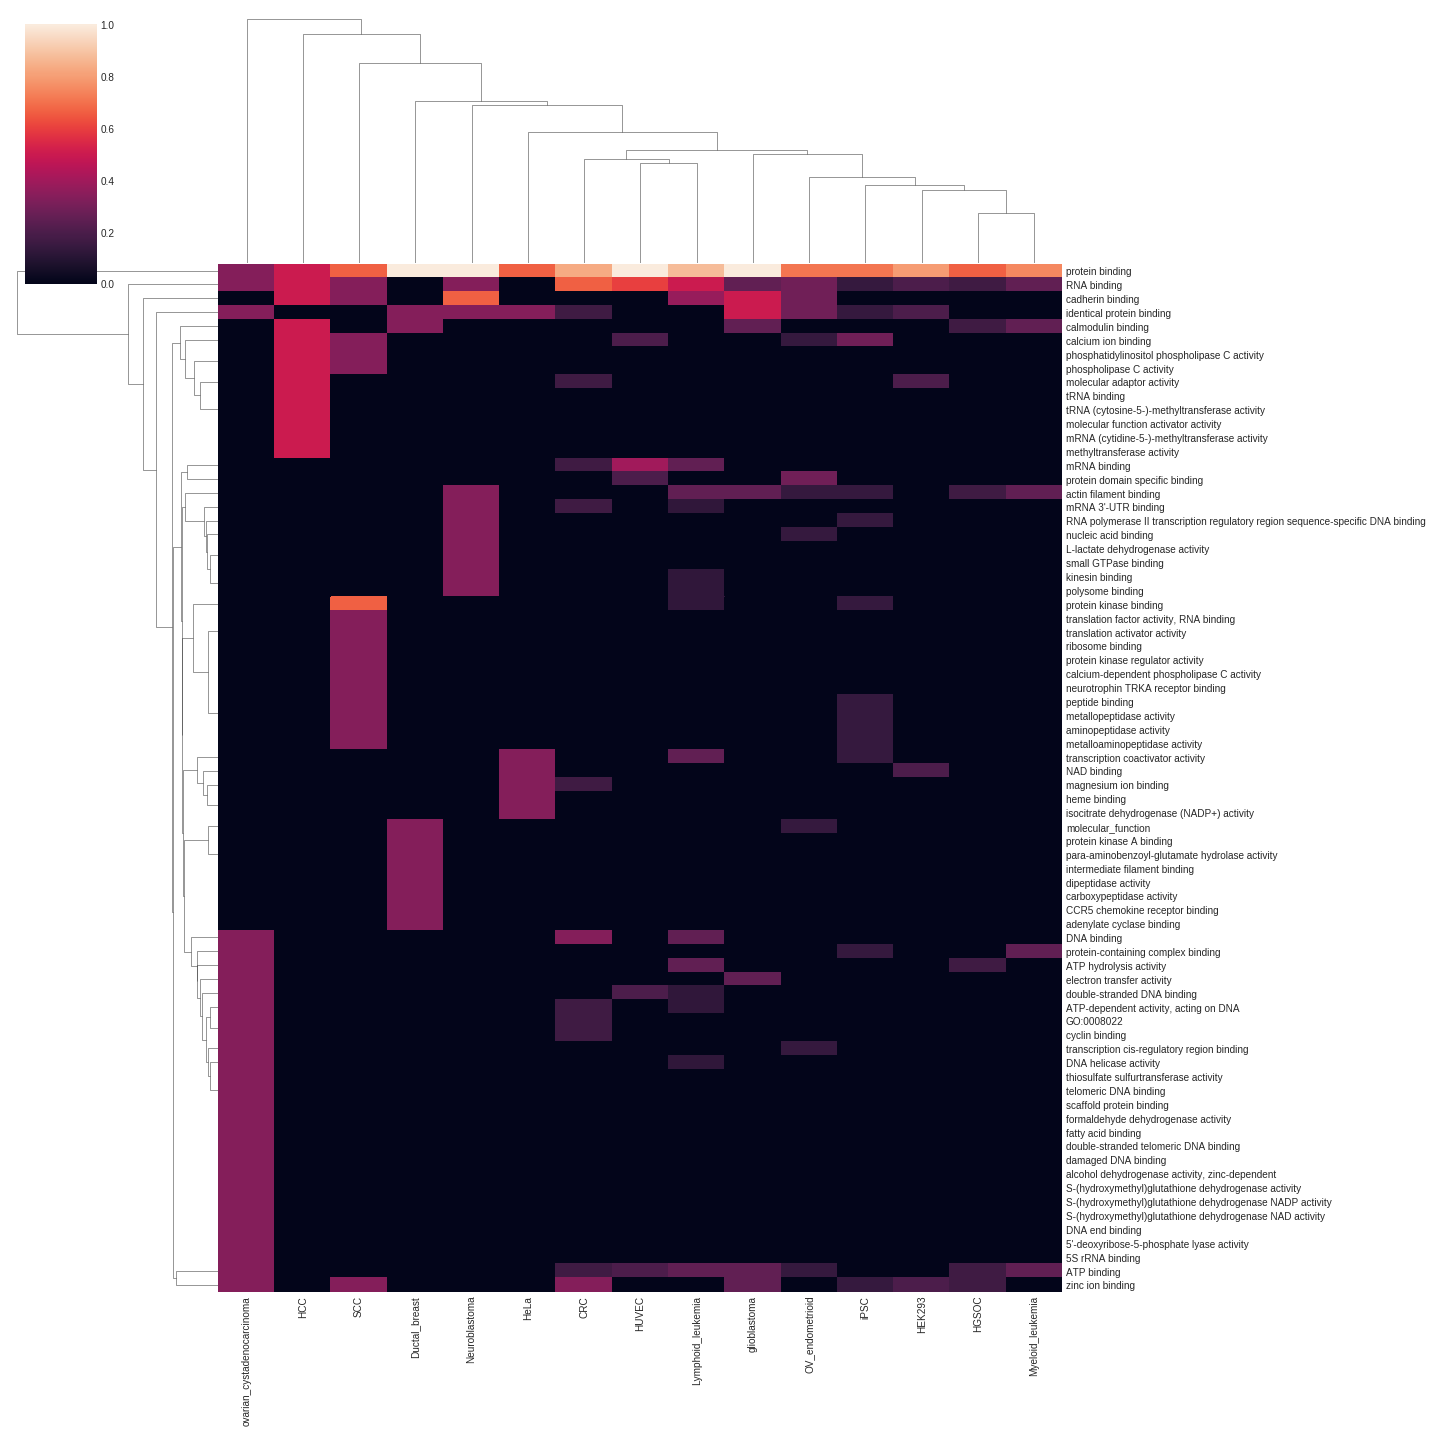

In [38]:
go_per_class_abundant = []
go_per_class_depleted = []

for i, prots in prots_per_class.items():

    ind = target_encoder.transform([i])[0]
    abundant_important_features = combined_shaps[ind].loc[prots].index[combined_shaps[ind].loc[prots].Abundance_rank > 7]
    depleted_important_features = combined_shaps[ind].loc[prots].index[combined_shaps[ind].loc[prots].Abundance_rank <= 7]

    go_per_class_abundant.append(calc_go(abundant_important_features, uniprot_go_function, missing_ontology_F).rename(i)/len(abundant_important_features))
    go_per_class_depleted.append(calc_go(depleted_important_features, uniprot_go_function, missing_ontology_F).rename(i)/len(depleted_important_features))

    print(len(abundant_important_features), len(depleted_important_features))

go_per_class_abundant = pd.concat(go_per_class_abundant,axis=1).fillna(0)
go_per_class_depleted = pd.concat(go_per_class_depleted,axis=1).fillna(0)

indices_abundant = go_per_class_abundant.index[(go_per_class_abundant<.9).any(axis=1) & (go_per_class_abundant>.25).any(axis=1)]
indices_depleted = go_per_class_depleted.index[(go_per_class_depleted<.9).any(axis=1) & (go_per_class_depleted>.25).any(axis=1)]

sns.clustermap(go_per_class_abundant.loc[indices_abundant], figsize=(20,20))
sns.clustermap(go_per_class_depleted.loc[indices_depleted], figsize=(20,20))

12 28
23 17
25 15
19 21
24 16
25 15
27 13
12 28
16 24
20 20
20 20
24 16
19 21
21 19
30 10


Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



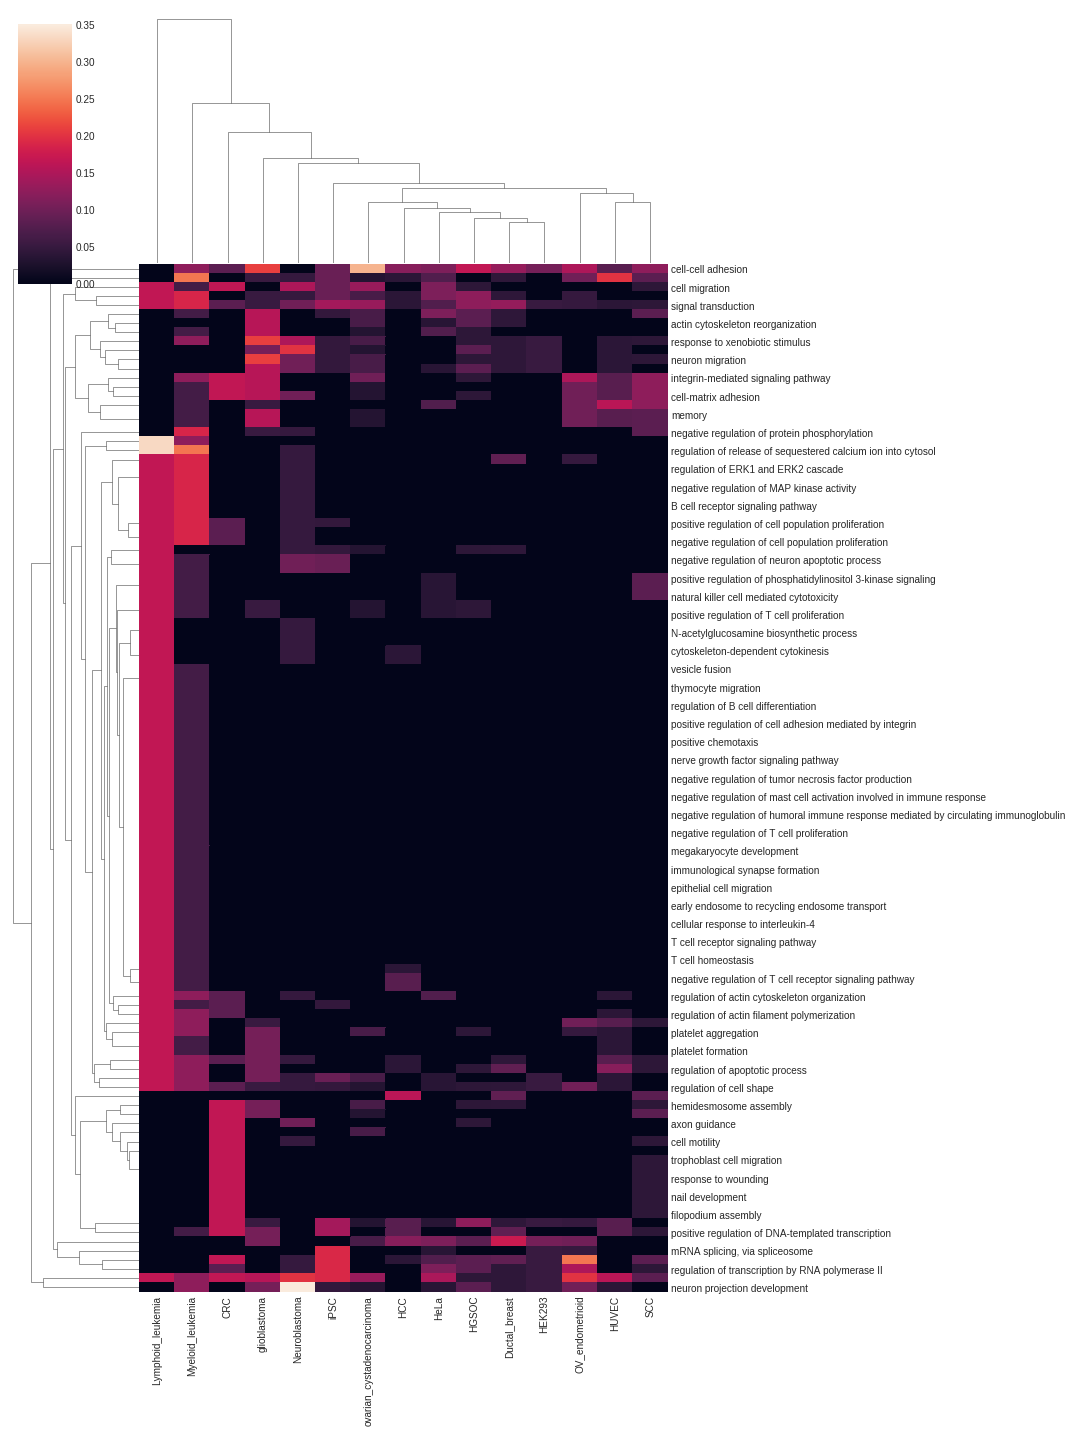

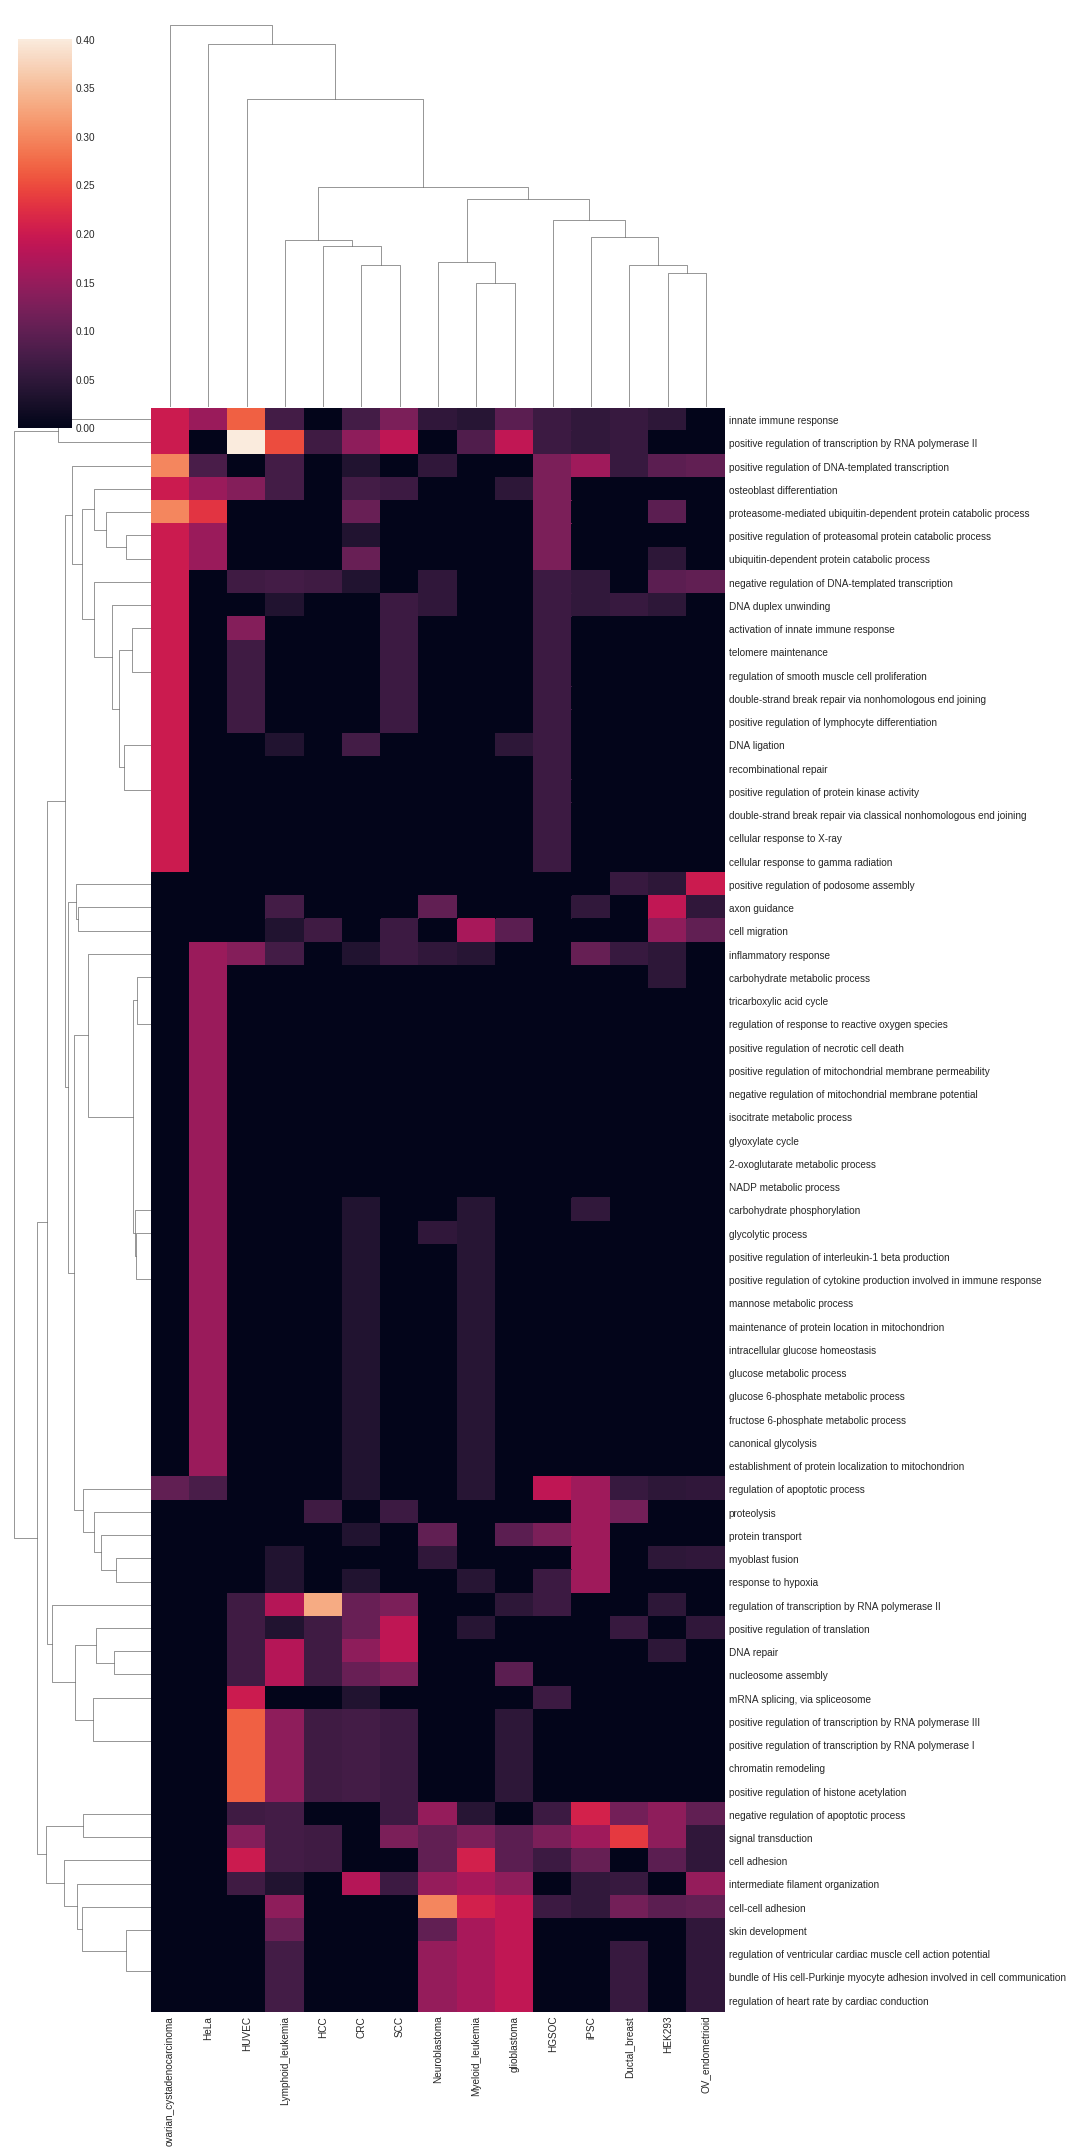

In [220]:
go_per_class_abundant = []
go_per_class_depleted = []

for i, prots in prots_per_class.items():

    ind = target_encoder.transform([i])[0]
    abundant_important_features = combined_shaps[ind].loc[prots].index[combined_shaps[ind].loc[prots].Abundance_rank > 7]
    depleted_important_features = combined_shaps[ind].loc[prots].index[combined_shaps[ind].loc[prots].Abundance_rank <= 7]

    go_per_class_abundant.append(calc_go(abundant_important_features, uniprot_go_process, missing_ontology_P).rename(i)/len(abundant_important_features))
    go_per_class_depleted.append(calc_go(depleted_important_features, uniprot_go_process, missing_ontology_P).rename(i)/len(depleted_important_features))

    print(len(abundant_important_features), len(depleted_important_features))

go_per_class_abundant = pd.concat(go_per_class_abundant,axis=1).fillna(0)
go_per_class_depleted = pd.concat(go_per_class_depleted,axis=1).fillna(0)

indices_abundant = go_per_class_abundant.index[(go_per_class_abundant>.15).any(axis=1)]
indices_depleted = go_per_class_depleted.index[(go_per_class_depleted>.15).any(axis=1)]

sns.clustermap(go_per_class_abundant.loc[indices_abundant], figsize=(15,20))
sns.clustermap(go_per_class_depleted.loc[indices_depleted], figsize=(15,30))

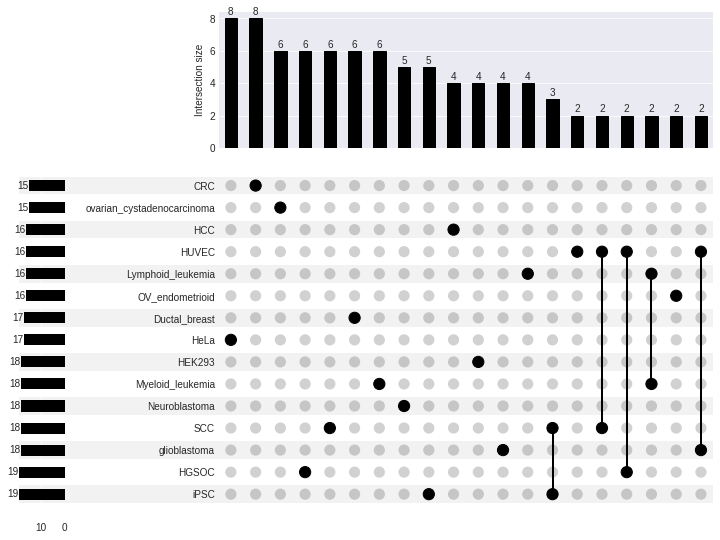

In [115]:
upset_cp = uplt.from_contents(prots_per_class)
uplt.UpSet(upset_cp, min_subset_size=2, show_counts=True, sort_by="cardinality")

In [116]:
def get_unique(dict_class_prots):
    class_specific = {}
    
    class_specific_prots = []
    all_prots = []
    for c, prots in dict_class_prots.items():
        all_prots += prots
    for prot in set(all_prots):
        # If the protein does not occur in more than 2 or 1 classes
        if all_prots.count(prot) < 3:
            class_specific_prots.append(prot)
    
    for c, prots in dict_class_prots.items():
        class_specific[c] = [prot for prot in prots if prot in class_specific_prots]
    return class_specific

In [117]:
ccl_specific_prots = get_unique(prots_per_class)

<BarContainer object of 15 artists>

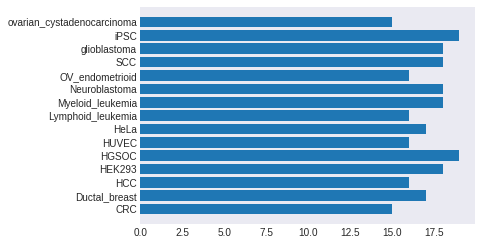

In [119]:
plt.barh(y=list(prots_per_class.keys()), width=[len(x) for x in prots_per_class.values()])

<BarContainer object of 15 artists>

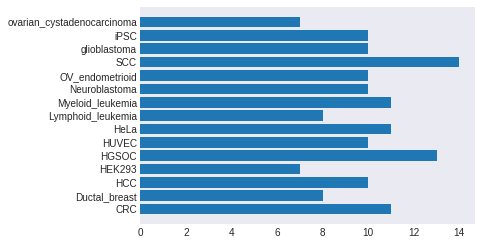

In [120]:
plt.barh(y=list(ccl_specific_prots.keys()), width=[len(x) for x in ccl_specific_prots.values()])

In [125]:
for c, prots in ccl_specific_prots.items():
    print(c)
    for prot in prots:
        print(uniprot_description.loc[prot][0])
    print("___________________")

CRC
E3 ubiquitin-protein ligase RBX1 
CAP-Gly domain-containing linker protein 2 
Scaffold attachment factor B2 
DNA topoisomerase 2-alpha 
Putative nascent polypeptide-associated complex subunit alpha-like protein 
RNA-binding protein 4 
Arf-GAP domain and FG repeat-containing protein 1 
Integrin beta-4 
Stomatin 
Parathymosin
Histone H4
___________________
Ductal_breast
Ethylmalonyl-CoA decarboxylase 
Glutathione S-transferase Mu 3 
Insulin-like growth factor 2 mRNA-binding protein 3 
Cellular retinoic acid-binding protein 2 
Carboxypeptidase D 
Delta-1-pyrroline-5-carboxylate dehydrogenase, mitochondrial 
Carbonyl reductase [NADPH] 3 
Moesin 
___________________
HCC
Dual specificity protein phosphatase 3 
UDP-glucose 6-dehydrogenase 
1-phosphatidylinositol 4,5-bisphosphate phosphodiesterase beta-3 
RNA cytosine C
Echinoderm microtubule-associated protein-like 4 
Aldehyde dehydrogenase, mitochondrial 
Inositol monophosphatase 1 
Glutathione S-transferase Mu 3 
Pyruvate carboxylase, m

---

# Cancer related proteins

In [34]:
columns_thpa = ['Uniprot',
                'Protein class',
                'Gene description',
                'Cell line expression cluster',
                'RNA cell line specificity',
                'RNA cell line distribution',
                'Pathology prognostics - Breast cancer',
                'Pathology prognostics - Cervical cancer',
                'Pathology prognostics - Colorectal cancer',
                'Pathology prognostics - Endometrial cancer',
                'Pathology prognostics - Glioma',
                'Pathology prognostics - Head and neck cancer',
                'Pathology prognostics - Liver cancer',
                'Pathology prognostics - Lung cancer',
                'Pathology prognostics - Melanoma',
                'Pathology prognostics - Ovarian cancer',
                'Pathology prognostics - Pancreatic cancer',
                'Pathology prognostics - Prostate cancer',
                'Pathology prognostics - Renal cancer',
                'Pathology prognostics - Stomach cancer',
                'Pathology prognostics - Testis cancer',
                'Pathology prognostics - Thyroid cancer',
                'Pathology prognostics - Urothelial cancer']

prognostics = ['Pathology prognostics - Breast cancer',
                'Pathology prognostics - Cervical cancer',
                'Pathology prognostics - Colorectal cancer',
                'Pathology prognostics - Endometrial cancer',
                'Pathology prognostics - Glioma',
                'Pathology prognostics - Head and neck cancer',
                'Pathology prognostics - Liver cancer',
                'Pathology prognostics - Lung cancer',
                'Pathology prognostics - Melanoma',
                'Pathology prognostics - Ovarian cancer',
                'Pathology prognostics - Pancreatic cancer',
                'Pathology prognostics - Prostate cancer',
                'Pathology prognostics - Renal cancer',
                'Pathology prognostics - Stomach cancer',
                'Pathology prognostics - Testis cancer',
                'Pathology prognostics - Thyroid cancer',
                'Pathology prognostics - Urothelial cancer']

In [35]:
cancer_related_genes = pd.read_csv("../annotation_files/THPA/cancer_related_genes.tsv", sep="\t", index_col="Uniprot", usecols=columns_thpa)

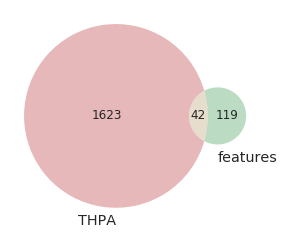

In [36]:
venn.venn2(subsets = (set(cancer_related_genes.index), set(features)), set_labels=("THPA", "features"))

In [ ]:
all_class_proteins = {"Group": [], "uniprot_id": []}
for i,x in prots_per_class.items():
    for x_ in x:
        all_class_proteins["uniprot_id"].append(x_)
        all_class_proteins["Group"].append(i)

In [58]:
all_class_proteins = pd.DataFrame(all_class_proteins)

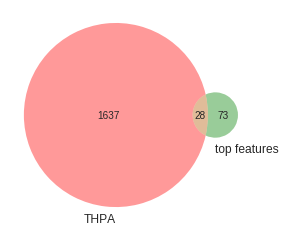

In [60]:
venn.venn2(subsets = (set(cancer_related_genes.index), set(all_class_proteins.uniprot_id)), set_labels=("THPA", "top features"))


In [61]:
for prot in set(cancer_related_genes.index).intersection(set(all_class_proteins.uniprot_id)):
    print(prot)

P16144
Q14116
P32119
P00338
P78527
Q16658
O75533
P26006
Q9HC35
Q14764
P12270
P12956
P11388
Q02952
P48735
P07948
Q9BZQ8
P11047
Q9Y5V3
P26447
Q08211
Q15149
Q8IVF2
Q14247
P17301
Q08380
Q14676
P19174


In [ ]:
for prot in set(cancer_related_genes.index).intersection(set(features)):
    print(prot)

In [62]:
cancer_related_genes_intersection = list(set(cancer_related_genes.index).intersection(set(features)))
cancer_related_genes = cancer_related_genes.loc[cancer_related_genes_intersection,:]

In [63]:
cancer_related_genes.loc[:,prognostics] = cancer_related_genes.loc[:,prognostics].applymap(lambda x: False if x[:12] == "unprognostic" else x)

In [64]:
prognostics_dict = {}
for prot, row in (cancer_related_genes.loc[:,prognostics] != False).iterrows():
    prognostic_classes = row.index[row]
    
    if len(prognostic_classes) > 0:
        prognostics_dict[prot] = [x.split(" - ")[1] for x in prognostic_classes]

In [65]:
cancer_related_genes = cancer_related_genes.loc[:,~cancer_related_genes.columns.isin(prognostics)]

In [66]:
cancer_related_genes["Cell line expression cluster"].value_counts()

Cluster 60: Keratinocytes - Epithelial cell function           5
Cluster 3: HUVEC & TIME - Signal transduction                  4
Cluster 19: Stomach & Colon cancer - Absorption                4
Cluster 22: Rhabdoid cancers - Neuronal signaling              2
Cluster 18: Non-specific - RNA binding                         2
Cluster 25: Non-specific - Basic cellular processes            2
Cluster 45: Non-specific - Cell proliferation                  2
Cluster 37: Ovarian cancer RMG-I - Cellular stress response    2
Cluster 46: Non-specific - Unknown function                    2
Cluster 61: Liver - Metabolism                                 1
Cluster 59: Fibroblasts - Metabolism                           1
Cluster 68: Kidney - Mixed function                            1
Cluster 54: Lymphoma - Cytokine signaling                      1
Cluster 39: Non-specific - Unknown function                    1
Cluster 30: Non-specific - Antiviral immune response           1
Cluster 53: Non-specific 

In [74]:
unique_prognostics_classes = []
for val in prognostics_dict.values():
    for v in val:
        if v not in unique_prognostics_classes:
            unique_prognostics_classes.append(v)
unique_prognostics_classes

['Lung cancer',
 'Pancreatic cancer',
 'Endometrial cancer',
 'Liver cancer',
 'Renal cancer',
 'Colorectal cancer',
 'Cervical cancer',
 'Head and neck cancer',
 'Melanoma',
 'Thyroid cancer',
 'Urothelial cancer',
 'Breast cancer']

In [67]:
def map_thpaPrognostics_to_features(summary):

    prognostic_match = {target_encoder.inverse_transform([i])[0]: {p: [] for p in unique_prognostics_classes} for i in range(15)}

    for i in range(15):
        summary_prots = summary[i].index.tolist()
        
        for summary_prot in summary_prots:
            if summary_prot in prognostics_dict.keys():
                
                for c in prognostics_dict[summary_prot]:
                    prognostic_match[target_encoder.inverse_transform([i])[0]][c].append(summary_prot)

    return prognostic_match

In [91]:
def parse_prognostics(p):
    prot_per_class = {c: [] for c in p.keys()} # Protein identifiers
    disease_per_class = {c: {} for c in p.keys()} # Disease biomarker counts
    
    for class_name, prog_dict in p.items():

        for cancer_type, prots in prog_dict.items():
            if len(prots) != 0:
                for prot in prots:
                    if prot not in prot_per_class[class_name]:
                        prot_per_class[class_name].append(prot)
                disease_per_class[class_name][cancer_type] = prots

    fig, ax1 = plt.subplots(1,1)
    ax1.set_title("# Unique protein prognostics found")
    ax1.barh(y=list(prot_per_class.keys()), width=[len(x) for x in prot_per_class.values()])

    return prot_per_class, disease_per_class

In [71]:
summaries_rf = []
summaries_lr = []
summaries_svc = []


for i in range(15):
    summaries_lr.append(get_summary_df(i, shap_lr_test, y_lr_correct, hard_threshold=.4, keep_only_enriched=False))

In [75]:
#svc_prognostics = map_thpaPrognostics_to_features(summaries_svc)
lr_prognostics = map_thpaPrognostics_to_features(summaries_lr)
#rf_prognostics = map_thpaPrognostics_to_features(summaries_rf)

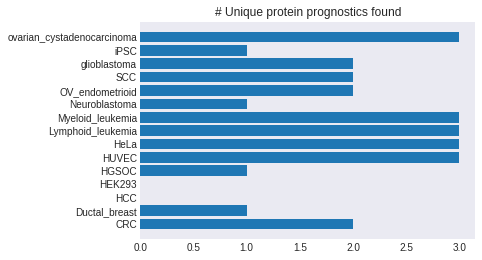

In [92]:
#prognostics_svc, dpc_svc = parse_prognostics(svc_prognostics)
prognostics_lr, dpc_lr = parse_prognostics(lr_prognostics)
#prognostics_rf, dpc_rf = parse_prognostics(rf_prognostics)

In [77]:
prognostics_lr

{'CRC': ['P11388', 'P16144'],
 'Ductal_breast': ['Q02952'],
 'HCC': [],
 'HEK293': [],
 'HGSOC': ['P32119'],
 'HUVEC': ['P78527', 'P12270', 'Q08380'],
 'HeLa': ['P26447', 'P48735', 'Q9Y5V3'],
 'Lymphoid_leukemia': ['P12270', 'Q08211', 'Q14247'],
 'Myeloid_leukemia': ['P17301', 'P07948', 'P11047'],
 'Neuroblastoma': ['P00338'],
 'OV_endometrioid': ['Q16658', 'Q9BZQ8'],
 'SCC': ['P19174', 'Q14116'],
 'glioblastoma': ['Q15149', 'P26006'],
 'iPSC': ['Q14764'],
 'ovarian_cystadenocarcinoma': ['Q02952', 'Q8IVF2', 'P26006']}

Let's sum the found prognostics for each model and add importance when one is found by muliple models. Additionally, investigate in the ppi network to what they are linked

In [243]:
def sum_prognostics(lr,rf):
    summed_prognostics_df = pd.DataFrame(columns=list(lr.keys()), index=list(prognostics_dict.keys()))

    for c in summed_prognostics_df.columns:
        prots = lr[c] + rf[c]

        for prot in set(prots):
            summed_prognostics_df.loc[prot,c] = prots.count(prot)
    
    return summed_prognostics_df

In [244]:
summed_prognostics_df = sum_prognostics(prognostics_lr, prognostics_rf)

In [245]:
summed_prognostics_df = summed_prognostics_df.dropna(axis=0, how="all")

In [ ]:
summed_prognostics_df.fillna(0).to_csv("prognostics_string_colorfile.csv")

In [84]:
prognostics_df = {"Group": [], "uniprot_id": []}
for i,x in prognostics_lr.items():
    if x != []:
        for x_ in x:
            prognostics_df["Group"].append(i)
            prognostics_df["uniprot_id"].append(x_)
prognostics_df = pd.DataFrame(prognostics_df).set_index("uniprot_id")

In [85]:
pd.concat([prognostics_df, uniprot_description], axis=1, join="inner")

Group  \
uniprot_id                               
P11388                             CRC   
P16144                             CRC   
Q02952                   Ductal_breast   
P32119                           HGSOC   
P78527                           HUVEC   
P12270                           HUVEC   
Q08380                           HUVEC   
P26447                            HeLa   
P48735                            HeLa   
Q9Y5V3                            HeLa   
P12270               Lymphoid_leukemia   
Q08211               Lymphoid_leukemia   
Q14247               Lymphoid_leukemia   
P17301                Myeloid_leukemia   
P07948                Myeloid_leukemia   
P11047                Myeloid_leukemia   
P00338                   Neuroblastoma   
Q16658                 OV_endometrioid   
Q9BZQ8                 OV_endometrioid   
P19174                             SCC   
Q14116                             SCC   
Q15149                    glioblastoma   
P26006                    glioblastoma   
Q14764                            iPSC   
Q02952      ovarian_cystadenocarcinoma   
Q8IVF2      ovarian_cystadenocarcinoma   
P26006      ovarian_cystadenocarcinoma   

                                                  description  
uniprot_id                                                     
P11388                             DNA topoisomerase 2-alpha   
P16144                                       Integrin beta-4   
Q02952                            A-kinase anchor protein 12   
P32119                                       Peroxiredoxin-2   
P78527        DNA-dependent protein kinase catalytic subunit   
P12270                                     Nucleoprotein TPR   
Q08380                            Galectin-3-binding protein   
P26447                                       Protein S100-A4   
P48735        Isocitrate dehydrogenase [NADP], mitochondrial   
Q9Y5V3                        Melanoma-associated antigen D1   
P12270                                     Nucleoprotein TPR   
Q08211                          ATP-dependent RNA helicase A   
Q14247                               Src substrate cortactin   
P17301                                      Integrin alpha-2   
P07948                           Tyrosine-protein kinase Lyn   
P11047                               Laminin subunit gamma-1   
P00338                       L-lactate dehydrogenase A chain   
Q16658                                                Fascin   
Q9BZQ8                                       Protein Niban 1   
P19174      1-phosphatidylinositol 4,5-bisphosphate phosph...  
Q14116                                        Interleukin-18   
Q15149                                               Plectin   
P26006                                      Integrin alpha-3   
Q14764                                   Major vault protein   
Q02952                            A-kinase anchor protein 12   
Q8IVF2                                         Protein AHNAK2  
P26006                                      Integrin alpha-3

In [89]:
prognostics_df.index.nunique()

24

In [247]:
pd.concat([summed_prognostics_df.loc[:,"SCC"].dropna(), uniprot_description], axis=1, join="inner")

SCC                                        description
Q9BZQ8   2                                   Protein Niban 1 
P08648   1                                  Integrin alpha-5 
P26006   1                                  Integrin alpha-3 
P16144   1                                   Integrin beta-4 
Q08211   1                      ATP-dependent RNA helicase A 
P19174   1  1-phosphatidylinositol 4,5-bisphosphate phosph...
Q14116   2                                    Interleukin-18 
P78527   1    DNA-dependent protein kinase catalytic subunit 
P31947   1                              14-3-3 protein sigma 
Q02952   1                        A-kinase anchor protein 12

In [252]:
uniprot_description.loc['Q02952 P31947 P04083 P05787 P05783 P08648 P62805'.split()]

description
uniprot_id                                  
Q02952           A-kinase anchor protein 12 
P31947                 14-3-3 protein sigma 
P04083                           Annexin A1 
P05787      Keratin, type II cytoskeletal 8 
P05783      Keratin, type I cytoskeletal 18 
P08648                     Integrin alpha-5 
P62805                            Histone H4

In [250]:
for keys, values in prognostics_lr.items():
    print(keys,values)

CRC ['P11388', 'P62805', 'P16144', 'P21266']
Ductal_breast ['P11388', 'Q15149', 'P48735', 'Q02952', 'Q9Y5V3', 'P05787', 'P21266']
HCC ['Q9BZQ8', 'P05783', 'P21266']
HEK293 ['P26447']
HGSOC ['P32119', 'P08648', 'P05783']
HUVEC ['Q08380', 'P08648', 'P46013', 'P12270', 'P23246', 'P78527']
HeLa ['P26447', 'P48735', 'Q14116', 'P19367', 'Q9Y5V3']
Lymphoid_leukemia ['P26006', 'Q14247', 'P12270', 'Q08211', 'P17301']
Myeloid_leukemia ['P11047', 'P07948', 'Q08380', 'P14923', 'P32119', 'Q14247', 'P17301', 'P19174']
Neuroblastoma ['P07948', 'P00338', 'P08648']
OV_endometrioid ['Q9BZQ8', 'Q16658', 'P08648', 'P05787']
SCC ['Q9BZQ8', 'Q14116', 'Q08211', 'P16144', 'P19174']
glioblastoma ['Q9BZQ8', 'Q15149', 'P14923', 'P62805', 'P07948', 'P26006']
iPSC ['Q14764']
ovarian_cystadenocarcinoma ['Q8IVF2', 'P11047', 'P26006', 'Q02952']


In [98]:
for g, p in dpc_lr.items():
    print(g)
    for cancer, prots in p.items():
        print("\t", cancer)
        for prot in prots:
            print("\t\t",uniprot_description.loc[prot].description)

CRC
	 Lung cancer
		 DNA topoisomerase 2-alpha 
		 Integrin beta-4 
	 Pancreatic cancer
		 DNA topoisomerase 2-alpha 
		 Integrin beta-4 
	 Liver cancer
		 DNA topoisomerase 2-alpha 
	 Renal cancer
		 DNA topoisomerase 2-alpha 
Ductal_breast
	 Lung cancer
		 A-kinase anchor protein 12 
	 Endometrial cancer
		 A-kinase anchor protein 12 
HCC
HEK293
HGSOC
	 Renal cancer
		 Peroxiredoxin-2 
HUVEC
	 Endometrial cancer
		 DNA-dependent protein kinase catalytic subunit 
	 Liver cancer
		 Nucleoprotein TPR 
	 Renal cancer
		 Galectin-3-binding protein 
	 Head and neck cancer
		 Nucleoprotein TPR 
HeLa
	 Renal cancer
		 Protein S100-A4 
	 Cervical cancer
		 Isocitrate dehydrogenase [NADP], mitochondrial 
	 Head and neck cancer
		 Protein S100-A4 
	 Thyroid cancer
		 Melanoma-associated antigen D1 
Lymphoid_leukemia
	 Liver cancer
		 Nucleoprotein TPR 
		 ATP-dependent RNA helicase A 
		 Src substrate cortactin 
	 Head and neck cancer
		 Nucleoprotein TPR 
		 Src substrate cortactin 
	 Melanoma

In [44]:
feature_names
cancer_related_genes.loc[cancer_related_genes.index.isin(feature_names),"Cell line expression cluster"].reset_index()

Uniprot                       Cell line expression cluster
0   Q8IVF2  Cluster 60: Keratinocytes - Epithelial cell fu...
1   Q02952      Cluster 3: HUVEC & TIME - Signal transduction
2   P04083  Cluster 22: Rhabdoid cancers - Neuronal signaling
3   Q14247  Cluster 58: Non-specific - Basic cellular proc...
4   Q08211             Cluster 18: Non-specific - RNA binding
5   Q9HC35  Cluster 22: Rhabdoid cancers - Neuronal signaling
6   Q16658      Cluster 50: L-1236 & L-428 - Unknown function
7   P21266                     Cluster 61: Liver - Metabolism
8   P62805      Cluster 1: Non-specific - Nucleosome assembly
9   P19367    Cluster 32: Myeloid leukemia - Oxygen transport
10  P48735    Cluster 19: Stomach & Colon cancer - Absorption
11  Q14116        Cluster 46: Non-specific - Unknown function
12  P17301      Cluster 3: HUVEC & TIME - Signal transduction
13  P26006  Cluster 37: Ovarian cancer RMG-I - Cellular st...
14  P08648      Cluster 3: HUVEC & TIME - Signal transduction
15  P16144  Cluster 60: Keratinocytes - Epithelial cell fu...
16  P14923    Cluster 19: Stomach & Colon cancer - Absorption
17  P05783  Cluster 60: Keratinocytes - Epithelial cell fu...
18  P05787  Cluster 60: Keratinocytes - Epithelial cell fu...
19  P11047               Cluster 59: Fibroblasts - Metabolism
20  P00338                Cluster 68: Kidney - Mixed function
21  Q08380  Cluster 30: Non-specific - Antiviral immune re...
22  P07948  Cluster 66: Myeloid cells - Innate immune resp...
23  Q9Y5V3             Cluster 48: Non-specific - RNA binding
24  Q14676         Cluster 15: Non-specific - Protein binding
25  P46013      Cluster 45: Non-specific - Cell proliferation
26  P26038      Cluster 3: HUVEC & TIME - Signal transduction
27  Q14764    Cluster 19: Stomach & Colon cancer - Absorption
28  Q9BZQ8          Cluster 54: Lymphoma - Cytokine signaling
29  P19174  Cluster 37: Ovarian cancer RMG-I - Cellular st...
30  Q15149  Cluster 25: Non-specific - Basic cellular proc...
31  P32119         Cluster 53: Non-specific - mRNA processing
32  P78527  Cluster 25: Non-specific - Basic cellular proc...
33  O75475         Cluster 41: Non-specific - Cilium assembly
34  P26447    Cluster 19: Stomach & Colon cancer - Absorption
35  O75533      Cluster 45: Non-specific - Cell proliferation
36  P31947  Cluster 60: Keratinocytes - Epithelial cell fu...
37  P23246         Cluster 38: Non-specific - mRNA processing
38  Q9UQE7  Cluster 67: Non-specific - Mitochondria & RNA ...
39  P11388        Cluster 46: Non-specific - Unknown function
40  P12270             Cluster 18: Non-specific - RNA binding
41  P12956        Cluster 39: Non-specific - Unknown function

In [54]:
group = 0
for i, row in class_specific.iterrows():
    if i == 0:
        group=row["Group"]
        print(group)
    if group != row["Group"]:
        group = row["Group"]
        print()
        print(group)
    if row["uniprot_id"] in cancer_related_genes.index:
        print("\t{} - {}".format(cancer_related_genes.loc[row["uniprot_id"], "Cell line expression cluster"], uniprot_description.loc[row["uniprot_id"]].description))
    

CRC
	Cluster 46: Non-specific - Unknown function - DNA topoisomerase 2-alpha 

Ductal_breast
	Cluster 3: HUVEC & TIME - Signal transduction - A-kinase anchor protein 12 
	Cluster 61: Liver - Metabolism - Glutathione S-transferase Mu 3 
	Cluster 25: Non-specific - Basic cellular processes - Plectin 
	Cluster 46: Non-specific - Unknown function - DNA topoisomerase 2-alpha 

HCC
	Cluster 22: Rhabdoid cancers - Neuronal signaling - Echinoderm microtubule-associated protein-like 4 

HEK293
	Cluster 15: Non-specific - Protein binding - Mediator of DNA damage checkpoint protein 1 

HGSOC
	Cluster 53: Non-specific - mRNA processing - Peroxiredoxin-2 

HUVEC
	Cluster 18: Non-specific - RNA binding - Nucleoprotein TPR 
	Cluster 45: Non-specific - Cell proliferation - Splicing factor 3B subunit 1 
	Cluster 30: Non-specific - Antiviral immune response - Galectin-3-binding protein 
	Cluster 25: Non-specific - Basic cellular processes - DNA-dependent protein kinase catalytic subunit 

HeLa
	Cluster 

In [ ]:
for g, p in dpc_lr.items():
    print(g)
    for cancer, prots in p.items():
        print("\t", cancer)
        for prot in prots:
            print("\t\t",uniprot_description.loc[prot].description)

In [106]:
pd.merge(all_class_proteins.rename(columns={"uniprot_id": "Uniprot"}), cancer_related_genes["Cell line expression cluster"].reset_index()).groupby(["Group", "Cell line expression cluster"]).count()

Uniprot
Group                      Cell line expression cluster                               
CRC                        Cluster 46: Non-specific - Unknown function               1
                           Cluster 60: Keratinocytes - Epithelial cell fun...        1
Ductal_breast              Cluster 3: HUVEC & TIME - Signal transduction             1
HCC                        Cluster 22: Rhabdoid cancers - Neuronal signaling         1
HEK293                     Cluster 15: Non-specific - Protein binding                1
HGSOC                      Cluster 53: Non-specific - mRNA processing                1
HUVEC                      Cluster 18: Non-specific - RNA binding                    1
                           Cluster 25: Non-specific - Basic cellular proce...        1
                           Cluster 30: Non-specific - Antiviral immune res...        1
                           Cluster 45: Non-specific - Cell proliferation             1
HeLa                       Cluster 19: Stomach & Colon cancer - Absorption           2
                           Cluster 48: Non-specific - RNA binding                    1
Lymphoid_leukemia          Cluster 18: Non-specific - RNA binding                    2
                           Cluster 58: Non-specific - Basic cellular proce...        1
Myeloid_leukemia           Cluster 3: HUVEC & TIME - Signal transduction             1
                           Cluster 59: Fibroblasts - Metabolism                      1
                           Cluster 66: Myeloid cells - Innate immune response        1
Neuroblastoma              Cluster 68: Kidney - Mixed function                       1
OV_endometrioid            Cluster 50: L-1236 & L-428 - Unknown function             1
                           Cluster 54: Lymphoma - Cytokine signaling                 1
SCC                        Cluster 37: Ovarian cancer RMG-I - Cellular str...        1
                           Cluster 46: Non-specific - Unknown function               1
glioblastoma               Cluster 25: Non-specific - Basic cellular proce...        1
                           Cluster 37: Ovarian cancer RMG-I - Cellular str...        1
iPSC                       Cluster 19: Stomach & Colon cancer - Absorption           1
ovarian_cystadenocarcinoma Cluster 37: Ovarian cancer RMG-I - Cellular str...        1
                           Cluster 39: Non-specific - Unknown function               1
                           Cluster 3: HUVEC & TIME - Signal transduction             1
                           Cluster 60: Keratinocytes - Epithelial cell fun...        1